<a href="https://colab.research.google.com/github/SicilianoBartolomeo/Human-activity-recognition/blob/main/HAR2_WISDM_0%2C8Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from operator import imod
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as krs
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, Conv1D, Bidirectional, LSTM
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn
from sklearn.model_selection import train_test_split
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [ ]:
import random
seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from datetime import datetime


experiment_time = datetime.now().isoformat()
folder_name = str(experiment_time).replace(":","_")[0:19]
folder_name

configuration_file_name = 'configuration.txt'

In [ ]:
dataset_path = 'Wisdm'
columns_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

In [ ]:
X_column_names = ['x_axis','y_axis','z_axis']
y_column_name = 'activity'

In [ ]:
time_steps_list = [600]
step_list =  [100]
use_magnitude = True
aggregate_falls = True
use_speed=False
use_total_speed=False
use_timestamp=False
use_squared_components=False
use_squared_speed=True
use_sign_speed=False
use_position=False

In [ ]:
leave_one_subject_out = True
stratified_test_set = False
leave_one_subject_out_with_validation_users = False
bilstm_one_subject_out = True

use_stats_in_cnn=False

In [ ]:
save_features = False

In [ ]:
batchsize = 64       ############

In [ ]:
from os import mkdir
mkdir(folder_name)

In [ ]:
config_file = open(folder_name + "/" + configuration_file_name,"a")
config_file.write("dataset: " + dataset_path +
"time_steps_list: " + str(time_steps_list) + 
"\nstep_list:" + str(step_list)+
"\nuse_magnitude: "+str(use_magnitude)+
"\naggregate_falls: "+str(aggregate_falls)+
"\nuse_speed: "+str(use_speed)+
"\nuse_total_speed: "+str(use_total_speed)+
"\nuse_timestamp: "+str(use_timestamp)+
"\nuse_squared_components: "+str(use_squared_components)+
"\nuse_squared_speed: "+str(use_squared_speed)+
"\nuse_sign_speed: "+str(use_sign_speed)+
"\nuse_position: "+str(use_position)
)
config_file.close()

# WISDM Dataset

In [ ]:
classes_to_rename = {
    'A': 'walking',
    'B': 'jogging',
    'C': 'stairs',
    'D': 'sitting',
    'E': 'standing',
    'F': 'typing',
    'G': 'teeth',
    'H': 'soup',
    'I': 'chips',
    'J': 'pasta',
    'K': 'drinking',
    'L': 'sandwich',
    'M': 'kicking',
    'O': 'catch',
    'P': 'dribbling',
    'Q': 'writing',
    'R': 'clapping',
    'S': 'folding'
}

In [ ]:
classes_to_consider = ['walking','jogging','stairs','sitting','standing',
    'typing', 'teeth','soup','chips','pasta','drinking','sandwich',
    'kicking','catch','dribbling','writing', 'clapping','folding']

In [ ]:
!sudo echo -ne '\n' | sudo add-apt-repository ppa:alessandro-strada/ppa >/dev/null 2>&1 # note: >/dev/null 2>&1 is used to supress printing
!sudo apt update >/dev/null 2>&1
!sudo apt install google-drive-ocamlfuse >/dev/null 2>&1
!google-drive-ocamlfuse
!sudo apt-get install w3m >/dev/null 2>&1 # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop >/dev/null 2>&1 # to set default browser 
%cd /content
!mkdir gdrive
%cd gdrive
!mkdir "My Drive"
!google-drive-ocamlfuse "/content/gdrive/My Drive"

/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force&state=Q2ovnWj9MjcJSeVbCOH%2FjZW5xWMqBCpLDKfB2Ix0UYc'
/bin/sh: 1: firefox: not found
/bin/sh: 1: google-chrome: not found
/bin/sh: 1: chromium-browser: not found
/bin/sh: 1: open: not found
Cannot retrieve auth tokens.
Failure("Error opening URL:https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
df = pd.DataFrame()
#loop to combine all data
for i in range(1600,1650):

    df1 = pd.read_csv(f'/content/gdrive/My Drive/wisdm-dataset/raw/watch/accel/data_{i}_accel_watch.txt', header=None, sep=',')
    #df1 = df1.loc[:, [0,1,2,3,4,5]]
    df1 = df1.rename(columns={
         0: 'user_id', 1: 'activity', 2: 'timestamp',
             3:'x_axis', 4: 'y_axis', 5: 'z_axis'
        })
    df = pd.concat([df,df1])

In [ ]:
df['z_axis'] = df['z_axis'].str.replace('\;*$', '', regex=True)
#df['z_axis'].apply(lambda x: float(x))
df['z_axis'] = df['z_axis'].astype(float)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3710454 entries, 0 to 65165
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    int64  
 1   activity   object 
 2   timestamp  int64  
 3   x_axis     float64
 4   y_axis     float64
 5   z_axis     float64
dtypes: float64(3), int64(2), object(1)
memory usage: 198.2+ MB


# Caricamento dati

In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

user_id      0
activity     0
timestamp    0
x_axis       0
y_axis       0
z_axis       0
dtype: int64

In [ ]:
df.head(10)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,1600,A,90426708196641,7.091625,-0.591667,8.195502
1,1600,A,90426757696641,4.972757,-0.158317,6.696732
2,1600,A,90426807196641,3.253720,-0.191835,6.107758
3,1600,A,90426856696641,2.801216,-0.155922,5.997625
4,1600,A,90426906196641,3.770868,-1.051354,7.731027
5,1600,A,90426955696641,4.661511,0.169689,9.684695
6,1600,A,90427005196641,6.145916,0.832883,11.003901
7,1600,A,90427054696641,7.259220,-0.792780,11.485135
8,1600,A,90427104196641,7.354988,-2.535759,11.454011
9,1600,A,90427153696641,7.319075,-2.700959,11.461193


In [ ]:
df.sample(10)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
101893,1629,K,379321564632449,3.397971,-7.316980,5.4617724;
40871,1628,J,912033330976107,3.517382,8.925284,-2.4628854;
51238,1612,P,7416767220606,2.814833,-12.155811,6.133945;
51060,1613,P,615955665554223,16.543634,9.867253,-1.4404116;
35549,1643,J,711697425727713,-4.135086,-5.862652,5.199907;
28658,1648,H,2529817622824177,8.890120,-3.937414,0.61650693;
57921,1649,Q,2720839886399455,-0.043545,-11.046398,0.07451953;
35580,1610,J,18181605516702,-1.359308,-7.120954,6.2744546;
38203,1621,I,180211771725794,-9.466824,-1.331775,-2.0376153;
63016,1649,S,2721172785907260,8.187721,-8.695291,-3.0116065;


In [ ]:
df.describe()

,user_id,timestamp,x_axis,y_axis
count,3.777046e+06,3.777046e+06,3.777046e+06,3.777046e+06
mean,1.626367e+03,6.072131e+14,3.831725e-01,-4.478842e+00
std,1.441509e+01,6.783433e+14,6.965694e+00,5.327486e+00
min,1.600000e+03,1.622154e+12,-7.063152e+01,-7.847761e+01
25%,1.614000e+03,8.371907e+13,-4.889259e+00,-8.045864e+00
50%,1.628000e+03,3.512653e+14,-4.186860e-01,-4.567987e+00
75%,1.639000e+03,9.100427e+14,5.705233e+00,-1.589451e+00
max,1.650000e+03,2.724599e+15,5.211323e+01,3.560197e+01


In [ ]:
df['activity']=df['activity'].apply(lambda x: classes_to_rename[x] if x in classes_to_rename.keys() else x)

In [ ]:
df = df[df['activity'].isin(classes_to_consider)]
df.reset_index(drop=True, inplace=True)

In [ ]:
df['activity'].unique()

array(['walking', 'jogging', 'stairs', 'sitting', 'standing', 'typing',
       'teeth', 'soup', 'chips', 'pasta', 'drinking', 'sandwich',
       'kicking', 'catch', 'dribbling', 'writing', 'clapping', 'folding'],
      dtype=object)

In [ ]:
df.sample(10)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
3007437,1640,typing,168074316741000,1.904041,-3.194956,-8.947793;
883955,1613,chips,614450455639521,-6.804621,-6.674286,0.86759883;
3527081,1647,sitting,726041302340550,-1.798345,-3.694104,8.59249;
513539,1607,writing,113957094075165,-0.585233,-8.865729,3.5019689;
2634875,1637,clapping,10988704940000,8.868757,-2.509981,4.598438;
3426282,1645,sandwich,1132620383891536,-1.090709,-3.804536,8.690803;
499999,1607,sandwich,118206614792130,9.553015,-1.423203,2.7907414;
870621,1613,standing,612615964904168,2.949357,-3.722235,8.6774845;
1775601,1626,folding,370840380154281,-10.235662,-0.216376,2.5219922;
547203,1608,teeth,726183417468174,-7.560889,-6.375011,5.5027733;


In [ ]:
import math

if use_magnitude:
    df['magnitude'] = np.sqrt(np.power(df['x_axis'],2) + np.power(df['y_axis'],2) + np.power(df['z_axis'],2))
    X_column_names.append('magnitude')
df.sample(10)

,user_id,activity,timestamp,x_axis,y_axis,z_axis,magnitude
3027087,1640,soup,169618924129000,-8.483160,-0.881367,-3.798501,9.336457
1918701,1629,jogging,901624410644509,13.814693,3.383905,1.032051,14.260494
3454999,1646,jogging,1470295000550304,4.833594,3.339014,-0.558897,5.901272
3542927,1647,soup,730079762283980,-9.640702,-0.817620,1.978509,9.875532
3461703,1646,sitting,1466306946096159,4.677223,-1.857900,8.485201,9.865437
3031083,1640,soup,169699453878000,-8.610096,-0.730481,-3.659590,9.384027
3317422,1644,jogging,1821831382879316,5.303755,-3.105729,-0.784251,6.196000
617582,1609,soup,856368183498341,-3.541623,-2.016666,7.311294,8.370487
3555456,1647,sandwich,730425667397779,-8.999056,-1.028310,3.654450,9.767059
2226118,1632,dribbling,7163942982413,3.276016,-3.623774,8.361450,9.683897


In [ ]:
classes = df['activity'].unique()
classes

array(['walking', 'jogging', 'stairs', 'sitting', 'standing', 'typing',
       'teeth', 'soup', 'chips', 'pasta', 'drinking', 'sandwich',
       'kicking', 'catch', 'dribbling', 'writing', 'clapping', 'folding'],
      dtype=object)

In [ ]:
if use_speed:
    records = []

    for index, row in df.iterrows():
        record = dict()
        if index==0 or (row['activity'])!=(df.iloc[index-1]['activity']):
            record['id']=index
            record['timestamp']=row['timestamp']
            record['v_x']=0
            record['v_y']=0
            record['v_z']=0
            record['x']=0
            record['y']=0
            record['z']=0
            record['v']=0
        else:
            prev_row = df.iloc[index-1]
            prev_record = records[-1]
            delta_t=(float(row['timestamp'])-float(prev_row['timestamp']))/1000
            record['id']=index
            record['timestamp']=row['timestamp']
            vx=float(prev_record['v_x'])+float(prev_row['x_axis'])*delta_t
            vy=float(prev_record['v_y'])+float(prev_row['y_axis'])*delta_t
            vz=float(prev_record['v_z'])+float(prev_row['z_axis'])*delta_t
            record['v_x']=vx
            record['v_y']=vy
            record['v_z']=vz
            x = float(prev_record['x']) + float(prev_record['v_x'])*delta_t + 0.5*float(prev_row['x_axis'])*(delta_t*delta_t)
            y = float(prev_record['x']) + float(prev_record['v_y'])*delta_t + 0.5*float(prev_row['y_axis'])*(delta_t*delta_t)
            z = float(prev_record['x']) + float(prev_record['v_z'])*delta_t + 0.5*float(prev_row['z_axis'])*(delta_t*delta_t)
            record['x']=x
            record['y']=y
            record['z']=z
            record['v']=np.sqrt(np.power(vx,2) + np.power(vy,2) + np.power(vz,2))
        records.append(record)

    df_velocità = pd.DataFrame(records, columns=['id','v_x','v_y','v_z','v','x','y','z'])
    df = pd.concat([df, df_velocità], axis=1).drop(columns=['id'])
    X_column_names+=['v_x','v_y','v_z','v']
    if not use_total_speed:
        X_column_names.remove('v')
    if use_position:
        X_column_names+=['x','y','z']
    df_velocità.head()

In [ ]:
df.head()

,user_id,timestamp,activity,x_axis,y_axis,z_axis,v_x,v_y,v_z,v,x,y,z
0,1,37.66,lying,2.21530,8.27915,5.58753,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,1,37.67,lying,2.29196,7.67288,5.74467,0.000022,0.000083,0.000056,0.000102,1.107650e-10,4.139575e-10,2.793765e-10
2,1,37.68,lying,2.29090,7.14240,5.82342,0.000045,0.000160,0.000113,0.000201,4.468930e-10,1.322324e-09,9.567515e-10
3,1,37.69,lying,2.21800,7.14365,5.89930,0.000068,0.000231,0.000172,0.000296,1.012164e-09,2.399216e-09,1.871284e-09
4,1,37.70,lying,2.30106,7.25857,6.09259,0.000090,0.000302,0.000231,0.000391,1.802880e-09,3.678790e-09,3.022691e-09


In [ ]:
if use_squared_components:
    df['x_axis_squared'] = np.square(df['x_axis'])
    df['y_axis_squared'] = np.square(df['y_axis'])
    df['z_axis_squared'] = np.square(df['z_axis'])
    X_column_names+=['x_axis_squared', 'y_axis_squared','z_axis_squared']

if use_squared_speed:
    df['vx2'] = np.square(df['v_x'])
    df['vy2'] = np.square(df['v_y'])
    df['vz2'] = np.square(df['v_z'])
    X_column_names+=['vx2','vy2','vz2']

if use_sign_speed:
    df['signvx']= np.sign(df['v_x'])  #df['v_x']/(np.abs(df['v_x'])+1)
    df['signvy']= np.sign(df['v_y'])  #df['v_y']/(np.abs(df['v_y'])+1)
    df['signvz']= np.sign(df['v_z'])  #df['v_z']/(np.abs(df['v_z'])+1)
    X_column_names+=['signvx','signvy','signvz']

In [ ]:
users_ids = df['user_id'].unique()
users_number = len(users_ids)
print("Numero totale di utenti:",users_number)

Numero totale di utenti: 50


In [ ]:
user_original_data = dict() #dict {user_id: dataframe_dati_utente_originali}
for users_id in users_ids:
    user_original_data[users_id]=df[df['user_id']==users_id]

In [ ]:
user_original_data.keys()

dict_keys([1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649])

In [ ]:
user_original_data[1600]

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,1600,walking,90426708196641,7.091625,-0.591667,8.195502
1,1600,walking,90426757696641,4.972757,-0.158317,6.696732
2,1600,walking,90426807196641,3.253720,-0.191835,6.107758
3,1600,walking,90426856696641,2.801216,-0.155922,5.997625
4,1600,walking,90426906196641,3.770868,-1.051354,7.731027
...,...,...,...,...,...,...
65457,1600,folding,82724332877212,3.271527,-7.406313,-1.863736
65458,1600,folding,82724382807252,4.720019,-5.680094,-5.270685
65459,1600,folding,82724432737292,8.126968,-8.143727,-5.076755
65460,1600,folding,82724482667332,7.542783,-8.885930,-3.630657


In [ ]:
from scipy import stats
def create_sliding_windows(data, time_steps=1, step=1):
  Xs = []
  for i in range(0, len(data) - time_steps, step):
    v = data.iloc[i: (i+time_steps)]
    

    Xs.append(v)
    
  return Xs

In [ ]:
user_trials = dict() #dict {user id: lista di trial dell'utente}

for users_id in users_ids:
    original_data = user_original_data[users_id]
    original_data.reset_index(inplace=True)
    #troviamo gli indici dei record iniziale di ogni trial (timestamp=0)
    index_start_trial = [0]
    for index, row in original_data.iterrows():
        if index==0:
            continue
        #if int(row['activity'])!=int(original_data.iloc[index-1]['activity']):
        if (row['activity'])!=(original_data.iloc[index-1]['activity']):
           # print("ok")
            index_start_trial.append(index)
    trials = []
    for i in range(len(index_start_trial)-1):
        trials.append(original_data.iloc[index_start_trial[i]:index_start_trial[i+1]-1])
    trials.append(original_data.iloc[index_start_trial[len(index_start_trial)-1]:])
    user_trials[users_id]=trials

In [ ]:
user_trials[3][2]

KeyError: ignored

In [ ]:
sliding_w_by_timestep=dict() #[timestep][steps][userid][indice trial][indice sliding window]

for time_steps in time_steps_list:
    sliding_w_by_step=dict()
    for step in step_list:
        user_sliding_windows = dict()  #[userid][indice trial][indice sliding window]
        for user_id in users_ids:
            user_trial_list = user_trials[user_id]
            num_trials = len(user_trial_list)  
            list_sliding_windows = []  
            for i in range(num_trials):
                trial = user_trial_list[i]
                sliding_window = create_sliding_windows(trial, time_steps, step)
                list_sliding_windows.append(sliding_window)
            user_sliding_windows[user_id]=list_sliding_windows    
        sliding_w_by_step[step]=user_sliding_windows
    sliding_w_by_timestep[time_steps]=sliding_w_by_step  

In [ ]:
trial

,index,user_id,activity,timestamp,x_axis,y_axis,z_axis
61563,3706851,1649,folding,2721100283758730,-5.883002,-7.285107,-0.502483
61564,3706852,1649,folding,2721100333258730,-5.169530,-10.457424,5.202900
61565,3706853,1649,folding,2721100382758730,-5.557391,3.211073,4.951509
61566,3706854,1649,folding,2721100432258730,-6.570138,-11.185262,0.816722
61567,3706855,1649,folding,2721100481758730,-3.586963,-4.390517,1.072902
...,...,...,...,...,...,...,...
65161,3710449,1649,folding,2721279933204170,3.250877,-10.519673,-5.209484
65162,3710450,1649,folding,2721279983147180,3.349039,-8.314613,-2.949357
65163,3710451,1649,folding,2721280033090190,2.039411,-9.131037,-0.370802
65164,3710452,1649,folding,2721280083033200,1.756895,-13.325678,-1.148918


In [ ]:
sliding_w_by_timestep[time_steps_list[0]][step_list[0]][1][0][0]

KeyError: ignored

In [ ]:
df_aggregate_feature_by_timestep = dict()
axes = ['x_axis','y_axis','z_axis']

for time_steps in time_steps_list:
    df_aggregate_feature_by_step = dict()
    for step in step_list:
        df_aggregate_feature_by_user = []
        for user_id in users_ids:
            df_aggregate_feature_by_trial=dict()
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                df_aggregate_feature_by_sliding_window = dict()
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    tupla = dict()
                    tupla['time_steps']=time_steps
                    tupla['step']=step
                    tupla['user_id']=user_id
                    tupla['trial']=trial
                    tupla['sliding_window']=sliding_window
                    tupla['activity']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window]['activity'].unique()[0]
                    
                    for axis in axes:
                        tupla[f'{axis}_mean']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].mean()
                        tupla[f'{axis}_devstd']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].std()
                        tupla[f'{axis}_power']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].pow(2).mean()                   
                    
                    
                    for k1, v1 in sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axes].cov().to_dict().items():
                        for k2, v2 in v1.items():
                            tupla[f"cov({k1},{k2})"]=v2

                    df_aggregate_feature_by_user.append(tupla)
                    
                    #df_aggregate_feature_by_sliding_window[sliding_window]=tupla
                #df_aggregate_feature_by_trial[trial]=df_aggregate_feature_by_sliding_window
            #df_aggregate_feature_by_user[user_id]=df_aggregate_feature_by_trial
        df_aggregate_feature_by_step[step]=pd.DataFrame(df_aggregate_feature_by_user)
    df_aggregate_feature_by_timestep[time_steps]=df_aggregate_feature_by_step


In [ ]:
df_aggregate_feature_by_timestep[time_steps_list[0]][step_list[0]]

,time_steps,step,user_id,trial,sliding_window,activity,x_axis_mean,x_axis_devstd,x_axis_power,y_axis_mean,...,z_axis_power,"cov(x_axis,x_axis)","cov(x_axis,y_axis)","cov(x_axis,z_axis)","cov(y_axis,x_axis)","cov(y_axis,y_axis)","cov(y_axis,z_axis)","cov(z_axis,x_axis)","cov(z_axis,y_axis)","cov(z_axis,z_axis)"
0,600,100,1,0,0,StandingStill,-2.913919,0.124591,8.506421,-9.137065,...,2.927027,0.015523,-0.002366,0.000483,-0.002366,0.010738,0.001293,0.000483,0.001293,0.013734
1,600,100,1,0,1,StandingStill,-2.934854,0.125581,8.629111,-9.131949,...,2.860133,0.015771,-0.002199,0.000220,-0.002199,0.010486,0.001547,0.000220,0.001547,0.014671
2,600,100,1,0,2,StandingStill,-2.956434,0.126773,8.756545,-9.129857,...,2.800738,0.016071,-0.001912,-0.000358,-0.001912,0.010785,0.002101,-0.000358,0.002101,0.013891
3,600,100,1,0,3,StandingStill,-2.969162,0.118665,8.829979,-9.132843,...,2.726334,0.014081,-0.001624,0.000299,-0.001624,0.010794,0.001464,0.000299,0.001464,0.012247
4,600,100,1,0,4,StandingStill,-2.997320,0.111062,8.996243,-9.129314,...,2.670609,0.012335,-0.000886,-0.000209,-0.000886,0.010501,0.001453,-0.000209,0.001453,0.012284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2750,600,100,10,11,0,JumpFrontBack,-6.635264,9.466314,133.488480,-4.512021,...,16.584951,89.611110,59.199037,-27.808903,59.199037,45.909004,-18.935020,-27.808903,-18.935020,12.690763
2751,600,100,10,11,1,JumpFrontBack,-6.476325,9.507916,132.192587,-4.143591,...,17.964854,90.400474,56.796421,-29.945796,56.796421,42.401329,-19.426219,-29.945796,-19.426219,13.922693
2752,600,100,10,11,2,JumpFrontBack,-6.393348,9.676111,134.345971,-4.154254,...,19.430631,93.627119,58.608675,-31.712160,58.608675,43.688705,-20.814367,-31.712160,-20.814367,15.110421
2753,600,100,10,11,3,JumpFrontBack,-6.129782,9.661786,130.768752,-3.921195,...,20.100687,93.350109,58.039478,-32.593311,58.039478,43.217231,-21.556425,-32.593311,-21.556425,15.770622


In [ ]:
import itertools

if save_features:
    for config in itertools.product(time_steps_list, step_list):
        time_step = config[0]
        step = config[1]
        
        example_list = []
        data = sliding_w_by_timestep[time_step][step]
        for user_id in users_ids:
            for trial in range(len(data[user_id])):
                for sliding_window in range(len(data[user_id][trial])):
                    for index, row in data[user_id][trial][sliding_window].iterrows():
                        item = row.to_dict()
                        item.update({'trial':trial,'sliding_window':sliding_window})
                        example_list.append(item)
        example_df = pd.DataFrame(example_list, columns=['trial','sliding_window']+list(sliding_w_by_timestep[time_step][step][users_ids[0]][0][0].columns))
        example_df.drop(columns="index", inplace=True)
        example_df.to_csv(f"{dataset_path.split('.')[0]}_{time_step}_{step}.csv")

In [ ]:
tuple_by_timestep=dict()
for time_steps in time_steps_list:
    tuple_by_step=dict()
    for step in step_list:
        tuple = dict()

        for user_id in users_ids:
            Xs = []
            ys = []
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    Xs.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][X_column_names]))
                    ys.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][y_column_name].unique()))
            tuple[user_id]=(Xs,ys)
        tuple_by_step[step]=tuple
    tuple_by_timestep[time_steps]=tuple_by_step        

In [ ]:
ignore_columns = ['time_steps', 'step', 'user_id', 'trial', 'activity', 'sliding_window']

tuple_by_timestep_with_stats=dict()
for time_steps in time_steps_list:
    tuple_by_step=dict()
    for step in step_list:
        tuple = dict()
        actual_df_stats = df_aggregate_feature_by_timestep[time_steps][step]
        feature_columns = [col_name for col_name in list(actual_df_stats.columns.values) if not col_name in ignore_columns]
        for user_id in users_ids:
            Xs = []
            ys = []
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    raw_and_feature = np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][X_column_names]).flatten().reshape(-1,1)
                    actual_row_stats = actual_df_stats.loc[(actual_df_stats['time_steps']==time_steps) & (actual_df_stats['step']==step) & (actual_df_stats['user_id']==user_id) & (actual_df_stats['trial']==trial) &(actual_df_stats['sliding_window']==sliding_window)]
                    aggregate_feature = np.array(actual_row_stats[feature_columns]).reshape(-1,1)
                    #aggregate_feature = np.array(list(df_aggregate_feature_by_timestep[time_steps][step][user_id][trial][sliding_window].values())[2:]).reshape(-1,1)
                    Xs.append(np.concatenate((raw_and_feature,aggregate_feature),axis=0))
                    ys.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][y_column_name].unique()))
            tuple[user_id]=(Xs,ys)
        tuple_by_step[step]=tuple
    tuple_by_timestep_with_stats[time_steps]=tuple_by_step     

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives/ (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# CNN

In [ ]:
cnn_dir = folder_name + "\\cnn"
leave_one_subject_out_dir = "\\leave_one_subject_out"
leave_one_subject_out_with_validation_user_dir =  "\\leave_one_subject_out_with_validation_user"
stratified_dir = "\\stratified"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

mkdir(cnn_dir )


In [ ]:
def createCNN(input_size, output_size):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape = input_size))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(Dropout(0.5))

    #model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())

    #model.add(LSTM(100))
    #model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu'))    
    model.add(Dense(256, activation='relu'))  
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu')) 
    model.add(Dense(128, activation='relu')) 
    model.add(Dense(128, activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_size, activation='softmax'))
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy',f1_m])

    cnn_config_file = open(cnn_dir+config_filename, "a")
    model.summary(print_fn=lambda x: cnn_config_file.write(x))
    cnn_config_file.close()
    
    return model

In [ ]:
from keras.layers.convolutional import MaxPooling1D
from keras.layers import TimeDistributed
def createCNN(input_size, output_size):
	iperparam = {"verbose": 0, "epochs": 15, "batch_size": 64}
	model = Sequential()
	model.add(LSTM(100, input_shape=(100,3)))
	model.add(Dropout(0.5))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(output_size, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


	return model

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

def model_builder(hp):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape = 3))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(Dropout(0.5))

    #model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())

    #model.add(LSTM(100))
    #model.add(Dropout(0.5))
    #hp = kt.HyperParameters()
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(Dense(hp_units, activation='relu'))    
    model.add(Dense(256, activation='relu'))  
    model.add(Dense(18, activation='softmax'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy',f1_m])
    
    return model


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [ ]:
import itertools
import gc
from tabnanny import verbose
from tkinter import Y
batchsize=128

if leave_one_subject_out:
    cnn_results_dict = []
    cnn_results = pd.DataFrame()
    try:
        mkdir(cnn_dir + leave_one_subject_out_dir)
        mkdir(cnn_dir + leave_one_subject_out_dir + plot_dir)
    except OSError as error:
        print(error)

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        cnn_f1_macro = []
        cnn_f1_weighted = []
        cnn_acc = []
        cnn_class_reports = []
        cnn_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:
            if user_id not in notConsider:

              print("Utente test: ", user_id)

              X_test = np.array(data_cnn[time_step][step][user_id][0])
              y_test = np.array(data_cnn[time_step][step][user_id][1])

              X_train = []
              y_train = []

              for id in users_ids:
                  if not id == user_id:
                      X_train += data_cnn[time_step][step][id][0]
                      y_train += data_cnn[time_step][step][id][1]
            
              X_train = np.array(X_train)
              y_train = np.array(y_train)

              scaler = RobustScaler()
              X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
              X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

              y_train = enc.transform(y_train)
              y_test = enc.transform(y_test)

              X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
              X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

      #      print(X_train)
       #     print(y_train)
        #    print(X_test)

         #   print(y_test)

              



              XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

              print("Training: x->",len(XTraining),"y->",len(YTraining))
              print("Validation: x->",len(XValidation),"y->",len(YValidation))
              print("Testing: x->",len(X_test),"y->",len(y_test))
              print("Total: x->",len(XTraining)+len(XValidation)+len(X_test),"y->",len(YTraining)+len(YValidation)+len(y_test))

              
   
              tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')
              stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

              tuner.search(XTraining, YTraining, epochs=50, validation_data=(XValidation,YValidation), callbacks=[stop_early])

# Get the optimal hyperparameters
              best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

              print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")
              gc.collect()            


600 100


NameError: ignored

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(np.array(classes).reshape(-1,1))

In [ ]:
import gc
gc.collect()

8

In [ ]:
if use_stats_in_cnn:
    data_cnn = tuple_by_timestep_with_stats
else:
    data_cnn = tuple_by_timestep

## CNN - Leave One Subject Out

In [ ]:
notConsider = [1601,1603,1607,1608,1609,1612,1613,1617,1618,1619,1620,1621,1622,1624,1628,1629,1633,1636,1637,1638,1639,1640,1642,1644,1648, 1626,1647]

[Errno 17] File exists: '2023-01-23T13_43_54\\cnn\\leave_one_subject_out'
600 100
Utente test:  1600
Training: x-> 25437 y-> 25437
Validation: x-> 6360 y-> 6360
Testing: x-> 563 y-> 563
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.2987 - accuracy: 0.1891 - f1_m: 0.1130 - val_loss: 2.2283 - val_accuracy: 0.2572 - val_f1_m: 0.1519
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.6617 - accuracy: 0.3904 - f1_m: 0.2903 - val_loss: 2.0325 - val_accuracy: 0.3266 - val_f1_m: 0.2652
Epoch 3/100
199/199 [==============================] - 7s 37ms/step - loss: 1.4360 - accuracy: 0.4894 - f1_m: 0.4075 - val_loss: 2.0213 - val_accuracy: 0.3852 - val_f1_m: 0.3243
Epoch 4/100
199/199 [==============================] - 7s 37ms/step - loss: 1.2250 - accuracy: 0.5617 - f1_m: 0.5141 - val_loss: 1.5018 - val_accuracy: 0.5146 - val_f1_m: 0.5093
Epoch 5/100
199/199 [==============================] - 7s 37ms/step - loss:

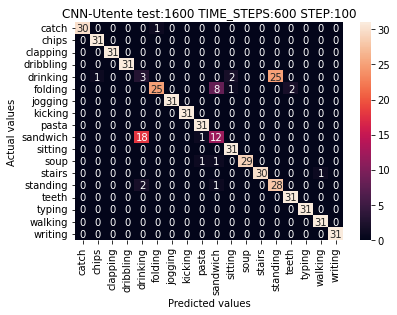

Utente test:  1602
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 40ms/step - loss: 2.2342 - accuracy: 0.2231 - f1_m: 0.1351 - val_loss: 2.3514 - val_accuracy: 0.2402 - val_f1_m: 0.1556
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.6605 - accuracy: 0.4104 - f1_m: 0.3117 - val_loss: 1.9479 - val_accuracy: 0.3587 - val_f1_m: 0.2542
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.4201 - accuracy: 0.5069 - f1_m: 0.4457 - val_loss: 1.8698 - val_accuracy: 0.3998 - val_f1_m: 0.3654
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2489 - accuracy: 0.5723 - f1_m: 0.5381 - val_loss: 1.6141 - val_accuracy: 0.4906 - val_f1_m: 0.4242
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1113 - accuracy: 0.6183 - f1_m: 0.5958 - val_loss: 1.5708 - val_accuracy: 0.516

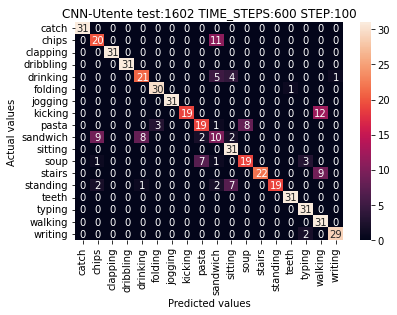

Utente test:  1604
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 40ms/step - loss: 2.3982 - accuracy: 0.1578 - f1_m: 0.0680 - val_loss: 2.4227 - val_accuracy: 0.1959 - val_f1_m: 0.0922
Epoch 2/100
199/199 [==============================] - 7s 38ms/step - loss: 1.8165 - accuracy: 0.3289 - f1_m: 0.2045 - val_loss: 1.9157 - val_accuracy: 0.3415 - val_f1_m: 0.2634
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.4783 - accuracy: 0.4583 - f1_m: 0.3754 - val_loss: 1.7232 - val_accuracy: 0.3965 - val_f1_m: 0.3466
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2927 - accuracy: 0.5229 - f1_m: 0.4698 - val_loss: 1.5588 - val_accuracy: 0.4583 - val_f1_m: 0.4177
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1488 - accuracy: 0.5729 - f1_m: 0.5269 - val_loss: 1.4404 - val_accuracy: 0.495

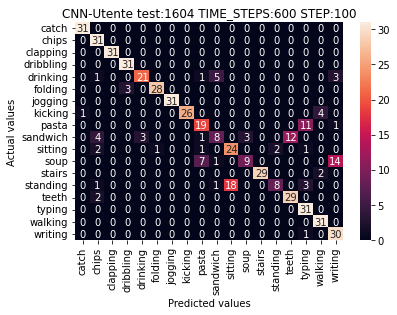

Utente test:  1605
Training: x-> 25431 y-> 25431
Validation: x-> 6358 y-> 6358
Testing: x-> 571 y-> 571
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 40ms/step - loss: 2.3072 - accuracy: 0.1662 - f1_m: 0.1046 - val_loss: 1.9982 - val_accuracy: 0.2595 - val_f1_m: 0.1985
Epoch 2/100
199/199 [==============================] - 7s 38ms/step - loss: 1.6940 - accuracy: 0.3706 - f1_m: 0.2754 - val_loss: 1.8002 - val_accuracy: 0.3525 - val_f1_m: 0.2877
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.4468 - accuracy: 0.4638 - f1_m: 0.3915 - val_loss: 1.5031 - val_accuracy: 0.4925 - val_f1_m: 0.4567
Epoch 4/100
199/199 [==============================] - 8s 39ms/step - loss: 1.2813 - accuracy: 0.5284 - f1_m: 0.4864 - val_loss: 1.4649 - val_accuracy: 0.5077 - val_f1_m: 0.4632
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1360 - accuracy: 0.5899 - f1_m: 0.5603 - val_loss: 1.2605 - val_accuracy: 0.574

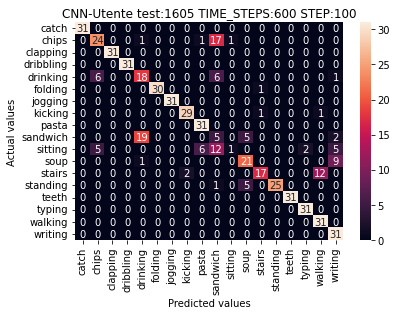

Utente test:  1606
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 38ms/step - loss: 2.2503 - accuracy: 0.1968 - f1_m: 0.1318 - val_loss: 1.8469 - val_accuracy: 0.3479 - val_f1_m: 0.2273
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.5960 - accuracy: 0.4185 - f1_m: 0.3234 - val_loss: 1.7223 - val_accuracy: 0.3853 - val_f1_m: 0.3235
Epoch 3/100
199/199 [==============================] - 7s 37ms/step - loss: 1.3345 - accuracy: 0.5051 - f1_m: 0.4528 - val_loss: 1.4570 - val_accuracy: 0.5079 - val_f1_m: 0.4368
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1567 - accuracy: 0.5637 - f1_m: 0.5233 - val_loss: 1.2569 - val_accuracy: 0.5443 - val_f1_m: 0.5363
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0316 - accuracy: 0.6140 - f1_m: 0.5827 - val_loss: 1.2994 - val_accuracy: 0.551

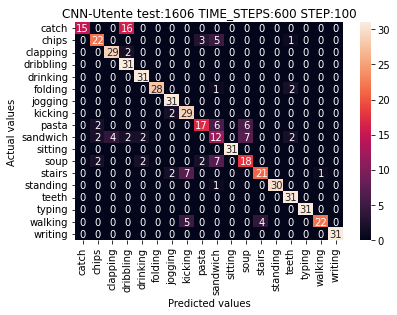

Utente test:  1610
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.3537 - accuracy: 0.1610 - f1_m: 0.0811 - val_loss: 2.3113 - val_accuracy: 0.2235 - val_f1_m: 0.0894
Epoch 2/100
199/199 [==============================] - 7s 38ms/step - loss: 1.7873 - accuracy: 0.3333 - f1_m: 0.2072 - val_loss: 1.8141 - val_accuracy: 0.3617 - val_f1_m: 0.2659
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.4390 - accuracy: 0.4669 - f1_m: 0.4000 - val_loss: 1.4430 - val_accuracy: 0.4969 - val_f1_m: 0.4214
Epoch 4/100
199/199 [==============================] - 7s 37ms/step - loss: 1.1965 - accuracy: 0.5588 - f1_m: 0.5281 - val_loss: 1.3016 - val_accuracy: 0.5620 - val_f1_m: 0.5119
Epoch 5/100
199/199 [==============================] - 7s 37ms/step - loss: 1.0466 - accuracy: 0.6145 - f1_m: 0.5911 - val_loss: 1.2383 - val_accuracy: 0.574

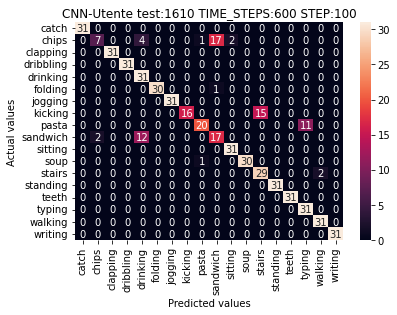

Utente test:  1611
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.2981 - accuracy: 0.1892 - f1_m: 0.1199 - val_loss: 2.2645 - val_accuracy: 0.2616 - val_f1_m: 0.1307
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.7248 - accuracy: 0.3667 - f1_m: 0.2683 - val_loss: 1.7520 - val_accuracy: 0.4124 - val_f1_m: 0.3270
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.4493 - accuracy: 0.4741 - f1_m: 0.3915 - val_loss: 1.5987 - val_accuracy: 0.4807 - val_f1_m: 0.3483
Epoch 4/100
199/199 [==============================] - 7s 38ms/step - loss: 1.2416 - accuracy: 0.5596 - f1_m: 0.5081 - val_loss: 1.3150 - val_accuracy: 0.5711 - val_f1_m: 0.5550
Epoch 5/100
199/199 [==============================] - 7s 38ms/step - loss: 1.0386 - accuracy: 0.6360 - f1_m: 0.6187 - val_loss: 1.2763 - val_accuracy: 0.616

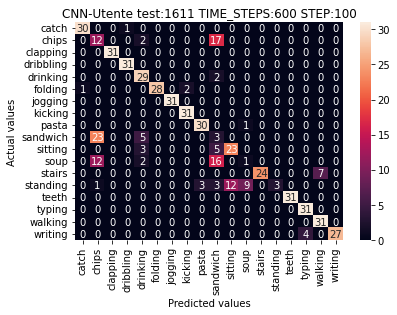

Utente test:  1614
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.3624 - accuracy: 0.1546 - f1_m: 0.0762 - val_loss: 2.0268 - val_accuracy: 0.2720 - val_f1_m: 0.0919
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.7225 - accuracy: 0.3747 - f1_m: 0.2571 - val_loss: 1.5854 - val_accuracy: 0.4341 - val_f1_m: 0.3351
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3330 - accuracy: 0.5227 - f1_m: 0.4631 - val_loss: 1.4536 - val_accuracy: 0.5068 - val_f1_m: 0.4345
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1076 - accuracy: 0.5903 - f1_m: 0.5587 - val_loss: 1.3579 - val_accuracy: 0.5581 - val_f1_m: 0.5556
Epoch 5/100
199/199 [==============================] - 8s 39ms/step - loss: 0.9710 - accuracy: 0.6398 - f1_m: 0.6240 - val_loss: 1.0211 - val_accuracy: 0.650

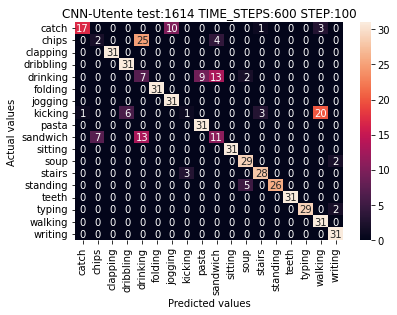

Utente test:  1615
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.2343 - accuracy: 0.2045 - f1_m: 0.1062 - val_loss: 1.8434 - val_accuracy: 0.3336 - val_f1_m: 0.2633
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.6573 - accuracy: 0.3946 - f1_m: 0.2722 - val_loss: 1.4550 - val_accuracy: 0.4696 - val_f1_m: 0.3967
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3449 - accuracy: 0.5163 - f1_m: 0.4473 - val_loss: 1.5309 - val_accuracy: 0.4705 - val_f1_m: 0.4062
Epoch 4/100
199/199 [==============================] - 8s 39ms/step - loss: 1.1475 - accuracy: 0.5898 - f1_m: 0.5516 - val_loss: 1.3404 - val_accuracy: 0.5636 - val_f1_m: 0.5214
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0084 - accuracy: 0.6372 - f1_m: 0.6137 - val_loss: 1.1440 - val_accuracy: 0.597

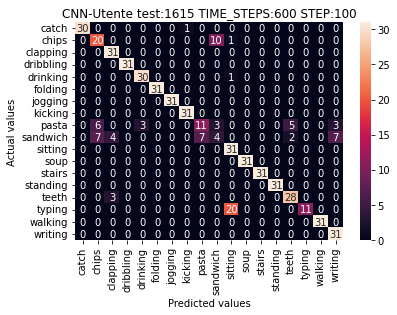

Utente test:  1616
Training: x-> 25466 y-> 25466
Validation: x-> 6367 y-> 6367
Testing: x-> 527 y-> 527
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 42ms/step - loss: 2.1686 - accuracy: 0.2336 - f1_m: 0.1680 - val_loss: 2.0509 - val_accuracy: 0.3094 - val_f1_m: 0.2494
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.5777 - accuracy: 0.4160 - f1_m: 0.3309 - val_loss: 2.1211 - val_accuracy: 0.3531 - val_f1_m: 0.2987
Epoch 3/100
199/199 [==============================] - 7s 37ms/step - loss: 1.3386 - accuracy: 0.5061 - f1_m: 0.4377 - val_loss: 1.9615 - val_accuracy: 0.4335 - val_f1_m: 0.3930
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1799 - accuracy: 0.5681 - f1_m: 0.5276 - val_loss: 1.7607 - val_accuracy: 0.4804 - val_f1_m: 0.4338
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0656 - accuracy: 0.6126 - f1_m: 0.5896 - val_loss: 1.6046 - val_accuracy: 0.540

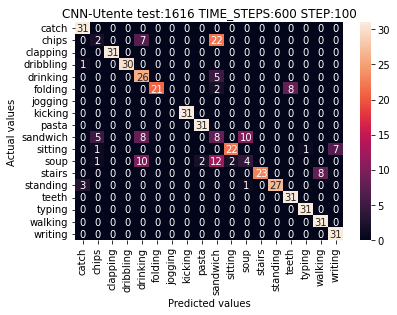

Utente test:  1623
Training: x-> 25442 y-> 25442
Validation: x-> 6361 y-> 6361
Testing: x-> 557 y-> 557
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 41ms/step - loss: 2.4202 - accuracy: 0.1436 - f1_m: 0.0567 - val_loss: 2.7809 - val_accuracy: 0.1302 - val_f1_m: 0.0521
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.8684 - accuracy: 0.3026 - f1_m: 0.1668 - val_loss: 2.2892 - val_accuracy: 0.2553 - val_f1_m: 0.1564
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.5089 - accuracy: 0.4501 - f1_m: 0.3734 - val_loss: 1.9129 - val_accuracy: 0.3636 - val_f1_m: 0.3017
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2894 - accuracy: 0.5303 - f1_m: 0.4912 - val_loss: 1.6118 - val_accuracy: 0.4793 - val_f1_m: 0.4531
Epoch 5/100
199/199 [==============================] - 7s 38ms/step - loss: 1.1483 - accuracy: 0.5895 - f1_m: 0.5551 - val_loss: 1.6931 - val_accuracy: 0.458

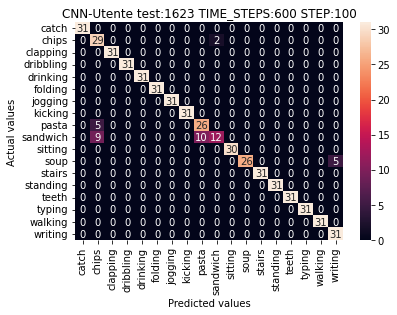

Utente test:  1625
Training: x-> 25427 y-> 25427
Validation: x-> 6357 y-> 6357
Testing: x-> 576 y-> 576
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 42ms/step - loss: 2.1935 - accuracy: 0.2206 - f1_m: 0.1230 - val_loss: 1.9972 - val_accuracy: 0.3261 - val_f1_m: 0.1758
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.5908 - accuracy: 0.4038 - f1_m: 0.2968 - val_loss: 1.5518 - val_accuracy: 0.4675 - val_f1_m: 0.3089
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3078 - accuracy: 0.5086 - f1_m: 0.4424 - val_loss: 1.2715 - val_accuracy: 0.5569 - val_f1_m: 0.4849
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1454 - accuracy: 0.5777 - f1_m: 0.5359 - val_loss: 1.2469 - val_accuracy: 0.5663 - val_f1_m: 0.5384
Epoch 5/100
199/199 [==============================] - 7s 38ms/step - loss: 1.0284 - accuracy: 0.6218 - f1_m: 0.5946 - val_loss: 1.2824 - val_accuracy: 0.594

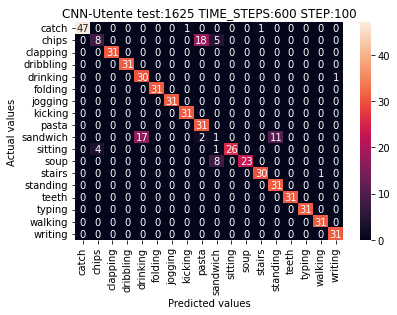

Utente test:  1626
Training: x-> 25422 y-> 25422
Validation: x-> 6356 y-> 6356
Testing: x-> 582 y-> 582
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 41ms/step - loss: 2.2779 - accuracy: 0.2009 - f1_m: 0.1408 - val_loss: 1.9962 - val_accuracy: 0.3065 - val_f1_m: 0.2613
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.6443 - accuracy: 0.4041 - f1_m: 0.3009 - val_loss: 2.0194 - val_accuracy: 0.3663 - val_f1_m: 0.3029
Epoch 3/100
199/199 [==============================] - 7s 38ms/step - loss: 1.2945 - accuracy: 0.5352 - f1_m: 0.4840 - val_loss: 1.6106 - val_accuracy: 0.4860 - val_f1_m: 0.4253
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1219 - accuracy: 0.5934 - f1_m: 0.5550 - val_loss: 1.4907 - val_accuracy: 0.5411 - val_f1_m: 0.4729
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0066 - accuracy: 0.6359 - f1_m: 0.6116 - val_loss: 1.3093 - val_accuracy: 0.595

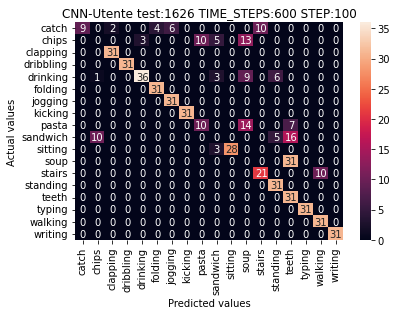

Utente test:  1627
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.3677 - accuracy: 0.1516 - f1_m: 0.0754 - val_loss: 2.5261 - val_accuracy: 0.1633 - val_f1_m: 0.0557
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.8398 - accuracy: 0.3237 - f1_m: 0.1960 - val_loss: 2.7180 - val_accuracy: 0.2800 - val_f1_m: 0.2593
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.4790 - accuracy: 0.4606 - f1_m: 0.3997 - val_loss: 1.7458 - val_accuracy: 0.4436 - val_f1_m: 0.3739
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2705 - accuracy: 0.5390 - f1_m: 0.4984 - val_loss: 1.8507 - val_accuracy: 0.4325 - val_f1_m: 0.3993
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1114 - accuracy: 0.5947 - f1_m: 0.5686 - val_loss: 1.6558 - val_accuracy: 0.506

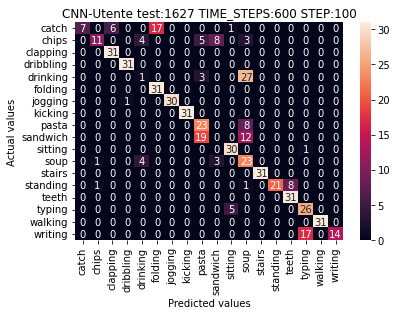

Utente test:  1630
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.3320 - accuracy: 0.1609 - f1_m: 0.0872 - val_loss: 2.1675 - val_accuracy: 0.2641 - val_f1_m: 0.0396
Epoch 2/100
199/199 [==============================] - 7s 38ms/step - loss: 1.7722 - accuracy: 0.3499 - f1_m: 0.2244 - val_loss: 1.8353 - val_accuracy: 0.3666 - val_f1_m: 0.2316
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3921 - accuracy: 0.5000 - f1_m: 0.4325 - val_loss: 1.7636 - val_accuracy: 0.4091 - val_f1_m: 0.3353
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1701 - accuracy: 0.5724 - f1_m: 0.5332 - val_loss: 1.7546 - val_accuracy: 0.5009 - val_f1_m: 0.4848
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0460 - accuracy: 0.6146 - f1_m: 0.5868 - val_loss: 1.2365 - val_accuracy: 0.596

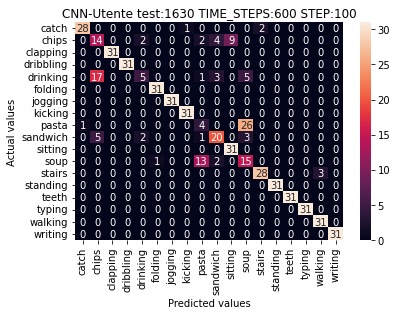

Utente test:  1631
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.2372 - accuracy: 0.1978 - f1_m: 0.1005 - val_loss: 2.1279 - val_accuracy: 0.2764 - val_f1_m: 0.1464
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.7289 - accuracy: 0.3537 - f1_m: 0.2566 - val_loss: 1.8250 - val_accuracy: 0.3676 - val_f1_m: 0.3342
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.4187 - accuracy: 0.4820 - f1_m: 0.4003 - val_loss: 1.6722 - val_accuracy: 0.4864 - val_f1_m: 0.4068
Epoch 4/100
199/199 [==============================] - 8s 39ms/step - loss: 1.2043 - accuracy: 0.5630 - f1_m: 0.5235 - val_loss: 1.5241 - val_accuracy: 0.5315 - val_f1_m: 0.4939
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0433 - accuracy: 0.6219 - f1_m: 0.5997 - val_loss: 1.3023 - val_accuracy: 0.571

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


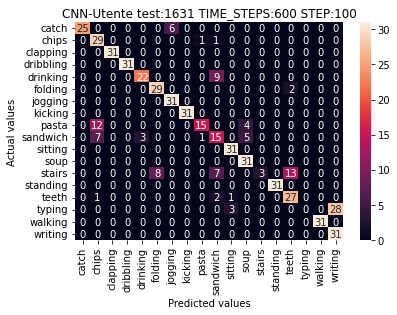

Utente test:  1632
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 40ms/step - loss: 2.3016 - accuracy: 0.1797 - f1_m: 0.0892 - val_loss: 2.4998 - val_accuracy: 0.2701 - val_f1_m: 0.1132
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.6494 - accuracy: 0.4101 - f1_m: 0.3175 - val_loss: 1.8766 - val_accuracy: 0.4023 - val_f1_m: 0.3290
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2845 - accuracy: 0.5496 - f1_m: 0.5056 - val_loss: 1.6082 - val_accuracy: 0.4977 - val_f1_m: 0.4750
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0956 - accuracy: 0.6057 - f1_m: 0.5834 - val_loss: 1.2624 - val_accuracy: 0.5538 - val_f1_m: 0.5482
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.9492 - accuracy: 0.6517 - f1_m: 0.6394 - val_loss: 1.1235 - val_accuracy: 0.612

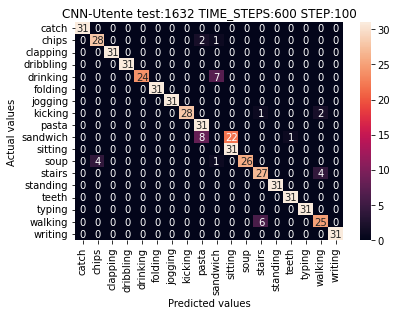

Utente test:  1634
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 40ms/step - loss: 2.3061 - accuracy: 0.2066 - f1_m: 0.1161 - val_loss: 2.3619 - val_accuracy: 0.2649 - val_f1_m: 0.2225
Epoch 2/100
199/199 [==============================] - 7s 38ms/step - loss: 1.6020 - accuracy: 0.4342 - f1_m: 0.3379 - val_loss: 1.7224 - val_accuracy: 0.4422 - val_f1_m: 0.3436
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3026 - accuracy: 0.5457 - f1_m: 0.4789 - val_loss: 1.5204 - val_accuracy: 0.5197 - val_f1_m: 0.4914
Epoch 4/100
199/199 [==============================] - 8s 39ms/step - loss: 1.0711 - accuracy: 0.6266 - f1_m: 0.6020 - val_loss: 1.4542 - val_accuracy: 0.5752 - val_f1_m: 0.5572
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.9346 - accuracy: 0.6725 - f1_m: 0.6573 - val_loss: 1.2997 - val_accuracy: 0.612

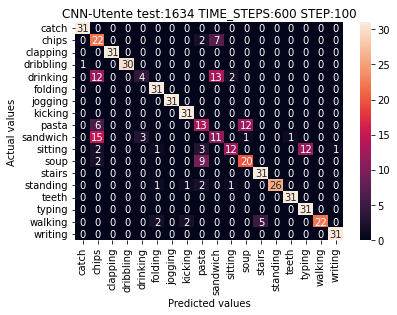

Utente test:  1635
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.1936 - accuracy: 0.2224 - f1_m: 0.1394 - val_loss: 1.9864 - val_accuracy: 0.3363 - val_f1_m: 0.2440
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.6245 - accuracy: 0.4023 - f1_m: 0.3278 - val_loss: 1.6063 - val_accuracy: 0.4219 - val_f1_m: 0.3975
Epoch 3/100
199/199 [==============================] - 7s 38ms/step - loss: 1.3799 - accuracy: 0.5033 - f1_m: 0.4572 - val_loss: 1.3442 - val_accuracy: 0.5405 - val_f1_m: 0.5142
Epoch 4/100
199/199 [==============================] - 8s 39ms/step - loss: 1.1726 - accuracy: 0.5775 - f1_m: 0.5576 - val_loss: 1.3101 - val_accuracy: 0.5689 - val_f1_m: 0.5554
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0428 - accuracy: 0.6194 - f1_m: 0.6027 - val_loss: 1.2100 - val_accuracy: 0.610

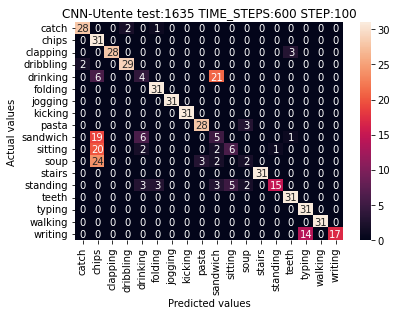

Utente test:  1641
Training: x-> 25455 y-> 25455
Validation: x-> 6364 y-> 6364
Testing: x-> 541 y-> 541
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 10s 45ms/step - loss: 2.2894 - accuracy: 0.1863 - f1_m: 0.1040 - val_loss: 1.9826 - val_accuracy: 0.3130 - val_f1_m: 0.1752
Epoch 2/100
199/199 [==============================] - 8s 39ms/step - loss: 1.6102 - accuracy: 0.3987 - f1_m: 0.3115 - val_loss: 1.6764 - val_accuracy: 0.4232 - val_f1_m: 0.2978
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3387 - accuracy: 0.5120 - f1_m: 0.4550 - val_loss: 1.4905 - val_accuracy: 0.4876 - val_f1_m: 0.4376
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1266 - accuracy: 0.5829 - f1_m: 0.5582 - val_loss: 1.2842 - val_accuracy: 0.5834 - val_f1_m: 0.5345
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.9669 - accuracy: 0.6422 - f1_m: 0.6256 - val_loss: 1.1029 - val_accuracy: 0.62

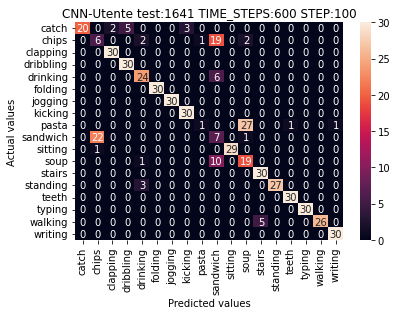

Utente test:  1643
Training: x-> 25454 y-> 25454
Validation: x-> 6364 y-> 6364
Testing: x-> 542 y-> 542
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 42ms/step - loss: 2.2806 - accuracy: 0.2013 - f1_m: 0.1021 - val_loss: 1.9825 - val_accuracy: 0.2993 - val_f1_m: 0.2186
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.5822 - accuracy: 0.4290 - f1_m: 0.3219 - val_loss: 1.8443 - val_accuracy: 0.4145 - val_f1_m: 0.3055
Epoch 3/100
199/199 [==============================] - 8s 39ms/step - loss: 1.3073 - accuracy: 0.5267 - f1_m: 0.4763 - val_loss: 1.4398 - val_accuracy: 0.4980 - val_f1_m: 0.4443
Epoch 4/100
199/199 [==============================] - 8s 39ms/step - loss: 1.1464 - accuracy: 0.5867 - f1_m: 0.5555 - val_loss: 1.2519 - val_accuracy: 0.5622 - val_f1_m: 0.5335
Epoch 5/100
199/199 [==============================] - 8s 39ms/step - loss: 1.0059 - accuracy: 0.6439 - f1_m: 0.6367 - val_loss: 1.2257 - val_accuracy: 0.601

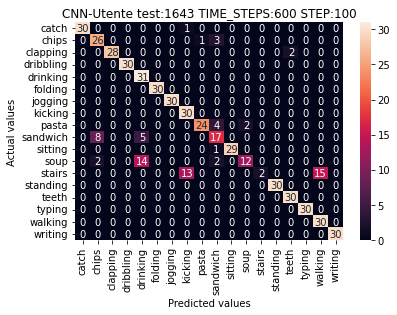

Utente test:  1645
Training: x-> 25430 y-> 25430
Validation: x-> 6358 y-> 6358
Testing: x-> 572 y-> 572
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 41ms/step - loss: 2.3339 - accuracy: 0.1673 - f1_m: 0.0880 - val_loss: 2.0126 - val_accuracy: 0.2708 - val_f1_m: 0.1209
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.6754 - accuracy: 0.3812 - f1_m: 0.2901 - val_loss: 1.7421 - val_accuracy: 0.3984 - val_f1_m: 0.3042
Epoch 3/100
199/199 [==============================] - 7s 38ms/step - loss: 1.4412 - accuracy: 0.4672 - f1_m: 0.4235 - val_loss: 1.9140 - val_accuracy: 0.3938 - val_f1_m: 0.3333
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3253 - accuracy: 0.5041 - f1_m: 0.4769 - val_loss: 1.5899 - val_accuracy: 0.4794 - val_f1_m: 0.4079
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2077 - accuracy: 0.5653 - f1_m: 0.5233 - val_loss: 1.3549 - val_accuracy: 0.553

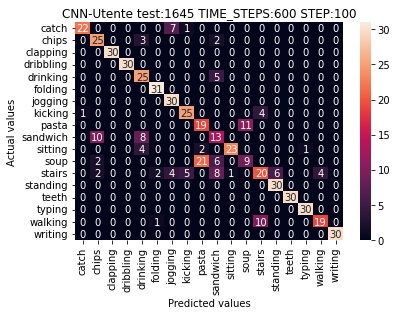

Utente test:  1646
Training: x-> 25455 y-> 25455
Validation: x-> 6364 y-> 6364
Testing: x-> 541 y-> 541
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 40ms/step - loss: 2.2666 - accuracy: 0.1938 - f1_m: 0.0972 - val_loss: 1.9968 - val_accuracy: 0.2998 - val_f1_m: 0.1521
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.6559 - accuracy: 0.3890 - f1_m: 0.2808 - val_loss: 1.8191 - val_accuracy: 0.3738 - val_f1_m: 0.2412
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.4239 - accuracy: 0.4835 - f1_m: 0.4045 - val_loss: 1.4957 - val_accuracy: 0.4690 - val_f1_m: 0.3738
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2395 - accuracy: 0.5581 - f1_m: 0.5056 - val_loss: 1.3919 - val_accuracy: 0.5233 - val_f1_m: 0.4960
Epoch 5/100
199/199 [==============================] - 8s 39ms/step - loss: 1.0685 - accuracy: 0.6168 - f1_m: 0.5976 - val_loss: 1.0928 - val_accuracy: 0.619

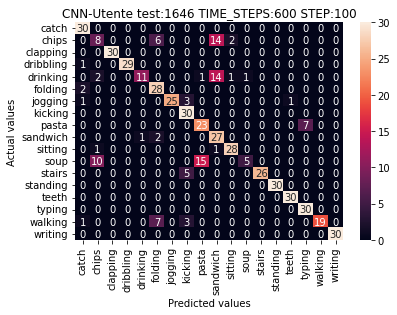

Utente test:  1647
Training: x-> 25436 y-> 25436
Validation: x-> 6360 y-> 6360
Testing: x-> 564 y-> 564
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 41ms/step - loss: 2.4754 - accuracy: 0.1526 - f1_m: 0.0518 - val_loss: 2.1000 - val_accuracy: 0.2648 - val_f1_m: 0.1280
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.7078 - accuracy: 0.3738 - f1_m: 0.2562 - val_loss: 1.6648 - val_accuracy: 0.4277 - val_f1_m: 0.3079
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3700 - accuracy: 0.4982 - f1_m: 0.4293 - val_loss: 1.8231 - val_accuracy: 0.4426 - val_f1_m: 0.3797
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1513 - accuracy: 0.5748 - f1_m: 0.5284 - val_loss: 1.6014 - val_accuracy: 0.4879 - val_f1_m: 0.4644
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0142 - accuracy: 0.6245 - f1_m: 0.5982 - val_loss: 1.1479 - val_accuracy: 0.603

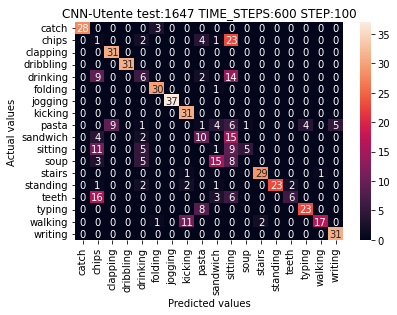

Utente test:  1649
Training: x-> 25440 y-> 25440
Validation: x-> 6360 y-> 6360
Testing: x-> 560 y-> 560
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 41ms/step - loss: 2.2526 - accuracy: 0.1935 - f1_m: 0.1214 - val_loss: 2.0906 - val_accuracy: 0.2931 - val_f1_m: 0.2126
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.6661 - accuracy: 0.3743 - f1_m: 0.2715 - val_loss: 1.9688 - val_accuracy: 0.3421 - val_f1_m: 0.2985
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.4716 - accuracy: 0.4530 - f1_m: 0.3831 - val_loss: 1.7370 - val_accuracy: 0.4332 - val_f1_m: 0.3829
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2914 - accuracy: 0.5320 - f1_m: 0.4683 - val_loss: 1.6633 - val_accuracy: 0.4931 - val_f1_m: 0.4699
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 1.1210 - accuracy: 0.5965 - f1_m: 0.5602 - val_loss: 1.4327 - val_accuracy: 0.564

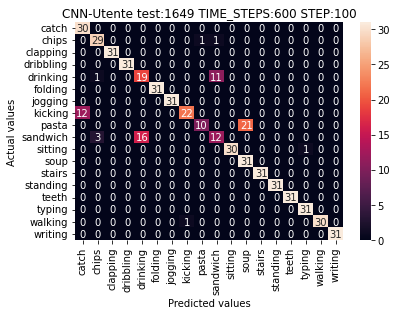

Accuracy media: 0.8061367306015087
F1 weighted media: 0.7922405319485408
F1 macro media: 0.7927194277410301
   Time Steps  Step  Average accuracy  Average F1 Weighted  Average F1 Macro  \
0         600   100          0.806137             0.792241          0.792719   

                                             reports  \
0  [              precision    recall  f1-score  ...   

                                    confusion_matrix  
0  [AxesSubplot(0.125,0.125;0.62x0.755), AxesSubp...  


In [ ]:
import itertools
import gc
from tabnanny import verbose
from tkinter import Y
batchsize=128

if leave_one_subject_out:
    cnn_results_dict = []
    cnn_results = pd.DataFrame()
    try:
        mkdir(cnn_dir + leave_one_subject_out_dir)
        mkdir(cnn_dir + leave_one_subject_out_dir + plot_dir)
    except OSError as error:
        print(error)

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        cnn_f1_macro = []
        cnn_f1_weighted = []
        cnn_acc = []
        cnn_class_reports = []
        cnn_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:
            if user_id not in notConsider:

              print("Utente test: ", user_id)

              X_test = np.array(data_cnn[time_step][step][user_id][0])
              y_test = np.array(data_cnn[time_step][step][user_id][1])

              X_train = []
              y_train = []

              for id in users_ids:
                  if not id == user_id:
                      X_train += data_cnn[time_step][step][id][0]
                      y_train += data_cnn[time_step][step][id][1]
            
              X_train = np.array(X_train)
              y_train = np.array(y_train)

              scaler = RobustScaler()
              X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
              X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

              y_train = enc.transform(y_train)
              y_test = enc.transform(y_test)

              X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
              X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

      #      print(X_train)
       #     print(y_train)
        #    print(X_test)

         #   print(y_test)

              model = createCNN(X_train[0].shape, y_train[0].shape[0])

              callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

              XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

              print("Training: x->",len(XTraining),"y->",len(YTraining))
              print("Validation: x->",len(XValidation),"y->",len(YValidation))
              print("Testing: x->",len(X_test),"y->",len(y_test))
              print("Total: x->",len(XTraining)+len(XValidation)+len(X_test),"y->",len(YTraining)+len(YValidation)+len(y_test))

              model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True, workers=10, use_multiprocessing=True )

              rounded_labels=np.argmax(y_test, axis=1)
              y_pred = np.argmax(model.predict(X_test), axis=-1)

              cnn_acc.append(accuracy_score(rounded_labels, y_pred))
              cnn_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
              cnn_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #cnn_f1.append(f1_m(rounded_labels,y_pred))

              class_report = classification_report(rounded_labels, y_pred, digits=4)
              print(class_report)
              cnn_class_reports.append(class_report)
            
              conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

              ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

              ax.set_title("CNN-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

              ax.set_xlabel('Predicted values')
              ax.set_ylabel('Actual values')

              ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
              ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

              ax.get_figure().savefig(cnn_dir + leave_one_subject_out_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
            #model_history_file=open(cnn_dir+'/'+ax.get_title().replace(":"," ")+".txt", "w")
            #model_history_file.write(model.history())
            #model_history_file.close()

              cnn_confusion_matrixes.append(ax)
              plt.show()

              gc.collect()            

        print("Accuracy media:",np.mean(cnn_acc))
        print("F1 weighted media:",np.mean(cnn_f1_weighted))
        print("F1 macro media:",np.mean(cnn_f1_macro))

        cnn_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(cnn_acc),
            'Average F1 Weighted': np.mean(cnn_f1_weighted),
            'Average F1 Macro': np.mean(cnn_f1_macro),
            'reports':cnn_class_reports,
            'confusion_matrix':cnn_confusion_matrixes
        })
        
        cnn_results = pd.DataFrame(cnn_results_dict)
        print(cnn_results)
        cnn_results.to_csv(cnn_dir + leave_one_subject_out_dir + result_filename)


600 100
Utente test:  1600
Training: x-> 25437 y-> 25437
Validation: x-> 6360 y-> 6360
Testing: x-> 563 y-> 563
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 17s 40ms/step - loss: 1.9765 - accuracy: 0.3227 - f1_m: 0.2199 - val_loss: 1.4708 - val_accuracy: 0.4645 - val_f1_m: 0.4208
Epoch 2/100
199/199 [==============================] - 7s 36ms/step - loss: 1.2548 - accuracy: 0.5519 - f1_m: 0.5112 - val_loss: 1.1280 - val_accuracy: 0.5970 - val_f1_m: 0.5618
Epoch 3/100
199/199 [==============================] - 7s 37ms/step - loss: 0.9999 - accuracy: 0.6407 - f1_m: 0.6218 - val_loss: 1.0295 - val_accuracy: 0.6327 - val_f1_m: 0.6153
Epoch 4/100
199/199 [==============================] - 7s 37ms/step - loss: 0.8457 - accuracy: 0.6963 - f1_m: 0.6837 - val_loss: 0.8982 - val_accuracy: 0.6803 - val_f1_m: 0.6678
Epoch 5/100
199/199 [==============================] - 7s 36ms/step - loss: 0.7295 - accuracy: 0.7370 - f1_m: 0.7330 - val_loss: 0.8260 - val_accura

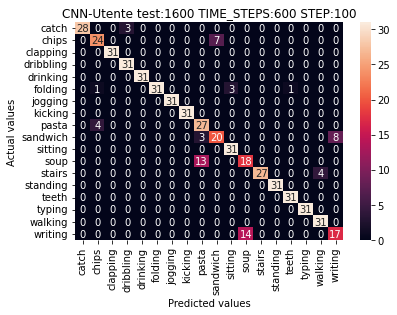

Utente test:  1602
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 40ms/step - loss: 2.0661 - accuracy: 0.2823 - f1_m: 0.1936 - val_loss: 1.7557 - val_accuracy: 0.3929 - val_f1_m: 0.2710
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.3772 - accuracy: 0.5051 - f1_m: 0.4438 - val_loss: 1.6590 - val_accuracy: 0.4757 - val_f1_m: 0.4299
Epoch 3/100
199/199 [==============================] - 7s 37ms/step - loss: 1.1346 - accuracy: 0.5921 - f1_m: 0.5523 - val_loss: 1.4131 - val_accuracy: 0.5377 - val_f1_m: 0.5158
Epoch 4/100
199/199 [==============================] - 7s 37ms/step - loss: 0.9605 - accuracy: 0.6550 - f1_m: 0.6374 - val_loss: 1.1097 - val_accuracy: 0.6172 - val_f1_m: 0.6042
Epoch 5/100
199/199 [==============================] - 7s 37ms/step - loss: 0.8275 - accuracy: 0.7045 - f1_m: 0.6959 - val_loss: 0.9762 - val_accuracy: 0.664

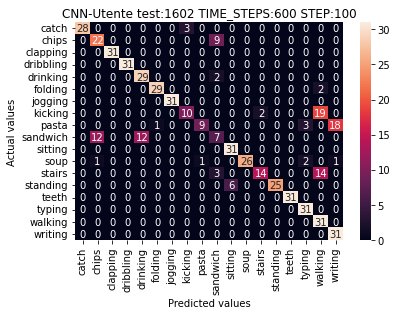

Utente test:  1604
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 39ms/step - loss: 2.0247 - accuracy: 0.3005 - f1_m: 0.2143 - val_loss: 1.6993 - val_accuracy: 0.4402 - val_f1_m: 0.3796
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.2925 - accuracy: 0.5418 - f1_m: 0.4956 - val_loss: 1.4059 - val_accuracy: 0.5175 - val_f1_m: 0.4978
Epoch 3/100
199/199 [==============================] - 7s 37ms/step - loss: 1.0418 - accuracy: 0.6241 - f1_m: 0.6010 - val_loss: 1.4017 - val_accuracy: 0.5543 - val_f1_m: 0.5486
Epoch 4/100
199/199 [==============================] - 7s 37ms/step - loss: 0.8954 - accuracy: 0.6815 - f1_m: 0.6690 - val_loss: 0.9212 - val_accuracy: 0.6779 - val_f1_m: 0.6697
Epoch 5/100
199/199 [==============================] - 7s 37ms/step - loss: 0.7473 - accuracy: 0.7326 - f1_m: 0.7292 - val_loss: 0.9794 - val_accuracy: 0.674

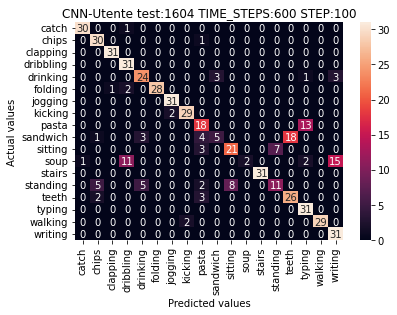

Utente test:  1605
Training: x-> 25431 y-> 25431
Validation: x-> 6358 y-> 6358
Testing: x-> 571 y-> 571
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 40ms/step - loss: 1.9565 - accuracy: 0.3425 - f1_m: 0.2476 - val_loss: 1.6710 - val_accuracy: 0.4256 - val_f1_m: 0.3614
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.2473 - accuracy: 0.5604 - f1_m: 0.5173 - val_loss: 1.1124 - val_accuracy: 0.6170 - val_f1_m: 0.5756
Epoch 3/100
199/199 [==============================] - 7s 37ms/step - loss: 0.9894 - accuracy: 0.6408 - f1_m: 0.6178 - val_loss: 1.0707 - val_accuracy: 0.6194 - val_f1_m: 0.6074
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 0.8155 - accuracy: 0.7064 - f1_m: 0.6940 - val_loss: 0.8475 - val_accuracy: 0.6977 - val_f1_m: 0.6802
Epoch 5/100
199/199 [==============================] - 7s 37ms/step - loss: 0.7242 - accuracy: 0.7376 - f1_m: 0.7310 - val_loss: 0.7957 - val_accuracy: 0.708

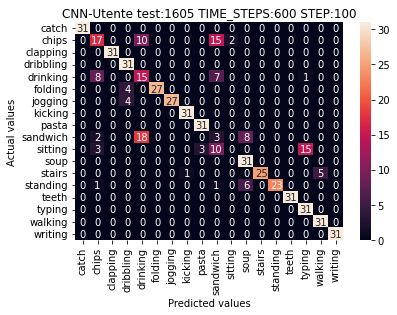

Utente test:  1606
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 39ms/step - loss: 1.9566 - accuracy: 0.3297 - f1_m: 0.2539 - val_loss: 1.4536 - val_accuracy: 0.4947 - val_f1_m: 0.4126
Epoch 2/100
199/199 [==============================] - 7s 38ms/step - loss: 1.2704 - accuracy: 0.5446 - f1_m: 0.4988 - val_loss: 1.1377 - val_accuracy: 0.5991 - val_f1_m: 0.5701
Epoch 3/100
199/199 [==============================] - 7s 38ms/step - loss: 0.9657 - accuracy: 0.6547 - f1_m: 0.6375 - val_loss: 1.1587 - val_accuracy: 0.5986 - val_f1_m: 0.5975
Epoch 4/100
199/199 [==============================] - 7s 37ms/step - loss: 0.7983 - accuracy: 0.7147 - f1_m: 0.7054 - val_loss: 0.9747 - val_accuracy: 0.6815 - val_f1_m: 0.6657
Epoch 5/100
199/199 [==============================] - 7s 37ms/step - loss: 0.6941 - accuracy: 0.7505 - f1_m: 0.7452 - val_loss: 0.8402 - val_accuracy: 0.704

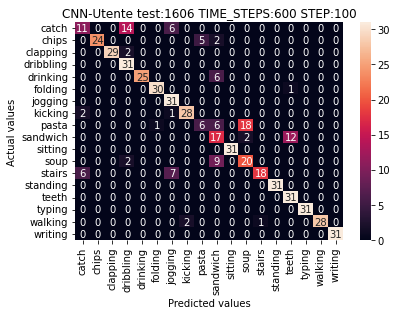

Utente test:  1610
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 39ms/step - loss: 2.0438 - accuracy: 0.3068 - f1_m: 0.2015 - val_loss: 1.5686 - val_accuracy: 0.4586 - val_f1_m: 0.3820
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.3430 - accuracy: 0.5237 - f1_m: 0.4739 - val_loss: 1.2166 - val_accuracy: 0.5606 - val_f1_m: 0.5330
Epoch 3/100
199/199 [==============================] - 7s 37ms/step - loss: 1.0610 - accuracy: 0.6170 - f1_m: 0.5916 - val_loss: 1.1111 - val_accuracy: 0.6114 - val_f1_m: 0.5773
Epoch 4/100
199/199 [==============================] - 7s 38ms/step - loss: 0.8939 - accuracy: 0.6788 - f1_m: 0.6640 - val_loss: 0.9473 - val_accuracy: 0.6678 - val_f1_m: 0.6567
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.7807 - accuracy: 0.7196 - f1_m: 0.7123 - val_loss: 0.8751 - val_accuracy: 0.684

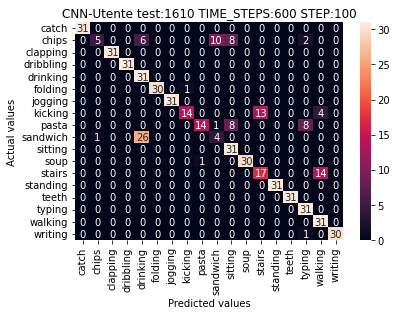

Utente test:  1611
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 40ms/step - loss: 2.0978 - accuracy: 0.2847 - f1_m: 0.1994 - val_loss: 1.6518 - val_accuracy: 0.4578 - val_f1_m: 0.3208
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.2835 - accuracy: 0.5494 - f1_m: 0.5029 - val_loss: 1.3866 - val_accuracy: 0.5241 - val_f1_m: 0.4881
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 0.9759 - accuracy: 0.6556 - f1_m: 0.6412 - val_loss: 1.0323 - val_accuracy: 0.6265 - val_f1_m: 0.6227
Epoch 4/100
199/199 [==============================] - 7s 38ms/step - loss: 0.8118 - accuracy: 0.7116 - f1_m: 0.7046 - val_loss: 0.9137 - val_accuracy: 0.6931 - val_f1_m: 0.6756
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.6897 - accuracy: 0.7495 - f1_m: 0.7462 - val_loss: 0.8201 - val_accuracy: 0.706

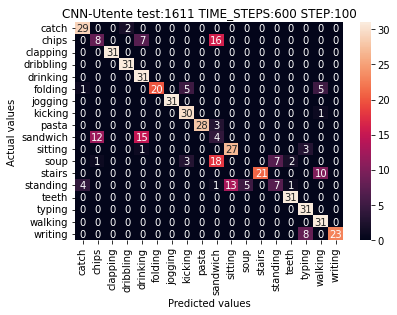

Utente test:  1614
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 39ms/step - loss: 2.1517 - accuracy: 0.2639 - f1_m: 0.1758 - val_loss: 1.7593 - val_accuracy: 0.3996 - val_f1_m: 0.3049
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.4259 - accuracy: 0.5045 - f1_m: 0.4436 - val_loss: 1.4102 - val_accuracy: 0.5141 - val_f1_m: 0.4716
Epoch 3/100
199/199 [==============================] - 7s 38ms/step - loss: 1.0908 - accuracy: 0.6219 - f1_m: 0.5943 - val_loss: 1.0945 - val_accuracy: 0.6351 - val_f1_m: 0.5869
Epoch 4/100
199/199 [==============================] - 7s 38ms/step - loss: 0.8943 - accuracy: 0.6817 - f1_m: 0.6728 - val_loss: 1.1201 - val_accuracy: 0.6328 - val_f1_m: 0.6296
Epoch 5/100
199/199 [==============================] - 7s 38ms/step - loss: 0.7983 - accuracy: 0.7149 - f1_m: 0.7087 - val_loss: 0.9272 - val_accuracy: 0.692

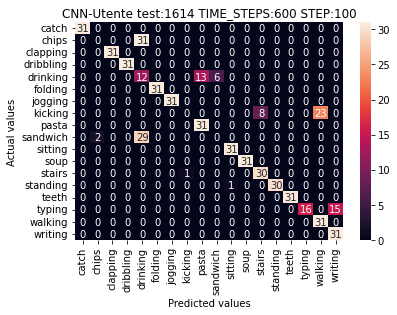

Utente test:  1615
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 39ms/step - loss: 1.9348 - accuracy: 0.3417 - f1_m: 0.2471 - val_loss: 1.6113 - val_accuracy: 0.4517 - val_f1_m: 0.4056
Epoch 2/100
199/199 [==============================] - 7s 38ms/step - loss: 1.2387 - accuracy: 0.5576 - f1_m: 0.5201 - val_loss: 1.1583 - val_accuracy: 0.5935 - val_f1_m: 0.5522
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 0.9798 - accuracy: 0.6406 - f1_m: 0.6253 - val_loss: 1.0255 - val_accuracy: 0.6460 - val_f1_m: 0.6228
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 0.8483 - accuracy: 0.6883 - f1_m: 0.6761 - val_loss: 0.9695 - val_accuracy: 0.6540 - val_f1_m: 0.6576
Epoch 5/100
199/199 [==============================] - 7s 37ms/step - loss: 0.7525 - accuracy: 0.7243 - f1_m: 0.7196 - val_loss: 0.8391 - val_accuracy: 0.694

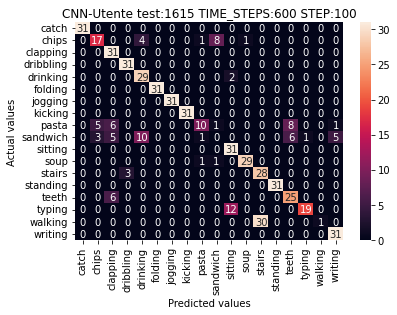

Utente test:  1616
Training: x-> 25466 y-> 25466
Validation: x-> 6367 y-> 6367
Testing: x-> 527 y-> 527
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 42ms/step - loss: 2.0059 - accuracy: 0.3116 - f1_m: 0.2240 - val_loss: 1.7505 - val_accuracy: 0.4362 - val_f1_m: 0.3210
Epoch 2/100
199/199 [==============================] - 7s 38ms/step - loss: 1.2875 - accuracy: 0.5381 - f1_m: 0.4957 - val_loss: 1.3453 - val_accuracy: 0.5362 - val_f1_m: 0.5262
Epoch 3/100
199/199 [==============================] - 7s 38ms/step - loss: 1.0415 - accuracy: 0.6220 - f1_m: 0.5993 - val_loss: 1.1850 - val_accuracy: 0.5816 - val_f1_m: 0.5708
Epoch 4/100
199/199 [==============================] - 7s 37ms/step - loss: 0.8866 - accuracy: 0.6757 - f1_m: 0.6630 - val_loss: 1.1063 - val_accuracy: 0.6177 - val_f1_m: 0.6118
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.7616 - accuracy: 0.7232 - f1_m: 0.7176 - val_loss: 0.9664 - val_accuracy: 0.657

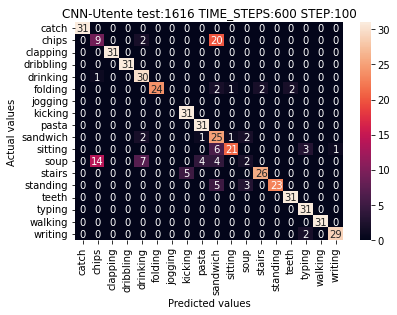

Utente test:  1623
Training: x-> 25442 y-> 25442
Validation: x-> 6361 y-> 6361
Testing: x-> 557 y-> 557
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 41ms/step - loss: 2.0277 - accuracy: 0.2963 - f1_m: 0.2165 - val_loss: 1.6647 - val_accuracy: 0.4485 - val_f1_m: 0.3625
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3081 - accuracy: 0.5355 - f1_m: 0.4887 - val_loss: 1.3490 - val_accuracy: 0.5372 - val_f1_m: 0.4840
Epoch 3/100
199/199 [==============================] - 7s 38ms/step - loss: 1.0262 - accuracy: 0.6285 - f1_m: 0.6028 - val_loss: 1.0382 - val_accuracy: 0.6203 - val_f1_m: 0.6208
Epoch 4/100
199/199 [==============================] - 7s 38ms/step - loss: 0.8417 - accuracy: 0.6959 - f1_m: 0.6833 - val_loss: 0.8661 - val_accuracy: 0.6892 - val_f1_m: 0.6788
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.7235 - accuracy: 0.7370 - f1_m: 0.7335 - val_loss: 0.7188 - val_accuracy: 0.737

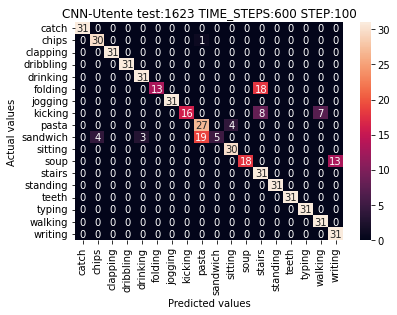

Utente test:  1625
Training: x-> 25427 y-> 25427
Validation: x-> 6357 y-> 6357
Testing: x-> 576 y-> 576
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 41ms/step - loss: 2.0108 - accuracy: 0.3147 - f1_m: 0.2270 - val_loss: 1.6479 - val_accuracy: 0.4271 - val_f1_m: 0.3279
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3105 - accuracy: 0.5290 - f1_m: 0.4805 - val_loss: 1.3419 - val_accuracy: 0.5342 - val_f1_m: 0.5164
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0251 - accuracy: 0.6245 - f1_m: 0.5987 - val_loss: 1.1251 - val_accuracy: 0.5990 - val_f1_m: 0.6042
Epoch 4/100
199/199 [==============================] - 7s 38ms/step - loss: 0.8737 - accuracy: 0.6775 - f1_m: 0.6636 - val_loss: 0.9438 - val_accuracy: 0.6714 - val_f1_m: 0.6517
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.7386 - accuracy: 0.7296 - f1_m: 0.7235 - val_loss: 0.8642 - val_accuracy: 0.705

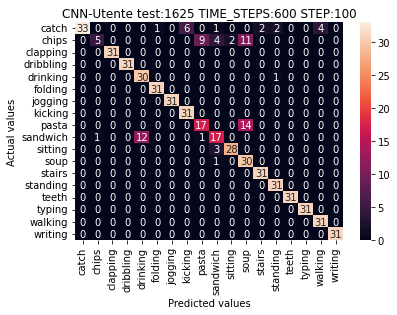

Utente test:  1626
Training: x-> 25422 y-> 25422
Validation: x-> 6356 y-> 6356
Testing: x-> 582 y-> 582
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 41ms/step - loss: 1.9933 - accuracy: 0.3143 - f1_m: 0.2240 - val_loss: 1.8809 - val_accuracy: 0.4100 - val_f1_m: 0.3146
Epoch 2/100
199/199 [==============================] - 7s 38ms/step - loss: 1.2905 - accuracy: 0.5378 - f1_m: 0.4852 - val_loss: 1.3186 - val_accuracy: 0.5363 - val_f1_m: 0.5086
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 0.9953 - accuracy: 0.6396 - f1_m: 0.6124 - val_loss: 1.1229 - val_accuracy: 0.6249 - val_f1_m: 0.6015
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 0.8170 - accuracy: 0.7042 - f1_m: 0.6907 - val_loss: 0.9674 - val_accuracy: 0.6710 - val_f1_m: 0.6595
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.7210 - accuracy: 0.7430 - f1_m: 0.7358 - val_loss: 0.8499 - val_accuracy: 0.720

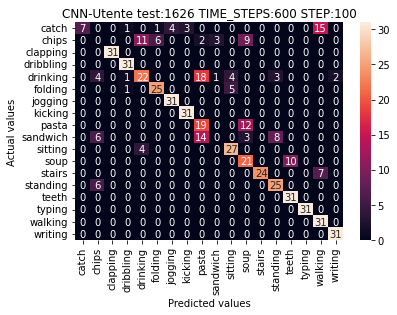

Utente test:  1627
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 39ms/step - loss: 2.0369 - accuracy: 0.3020 - f1_m: 0.2148 - val_loss: 1.6838 - val_accuracy: 0.4524 - val_f1_m: 0.3852
Epoch 2/100
199/199 [==============================] - 7s 38ms/step - loss: 1.2862 - accuracy: 0.5464 - f1_m: 0.5080 - val_loss: 1.2590 - val_accuracy: 0.5553 - val_f1_m: 0.5410
Epoch 3/100
199/199 [==============================] - 7s 37ms/step - loss: 0.9952 - accuracy: 0.6391 - f1_m: 0.6210 - val_loss: 1.1152 - val_accuracy: 0.6246 - val_f1_m: 0.6237
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 0.8401 - accuracy: 0.6948 - f1_m: 0.6828 - val_loss: 0.9687 - val_accuracy: 0.6562 - val_f1_m: 0.6626
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.7223 - accuracy: 0.7352 - f1_m: 0.7304 - val_loss: 0.9285 - val_accuracy: 0.692

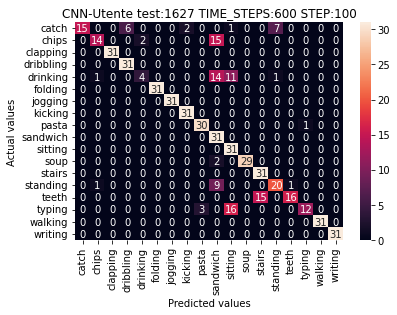

Utente test:  1630
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 1.9996 - accuracy: 0.3250 - f1_m: 0.2356 - val_loss: 1.6215 - val_accuracy: 0.4701 - val_f1_m: 0.3733
Epoch 2/100
199/199 [==============================] - 7s 37ms/step - loss: 1.2780 - accuracy: 0.5520 - f1_m: 0.5196 - val_loss: 1.2380 - val_accuracy: 0.5656 - val_f1_m: 0.5474
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0010 - accuracy: 0.6411 - f1_m: 0.6316 - val_loss: 1.1452 - val_accuracy: 0.6065 - val_f1_m: 0.5974
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 0.8551 - accuracy: 0.6969 - f1_m: 0.6937 - val_loss: 0.8921 - val_accuracy: 0.6832 - val_f1_m: 0.6667
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.7109 - accuracy: 0.7464 - f1_m: 0.7459 - val_loss: 0.8423 - val_accuracy: 0.705

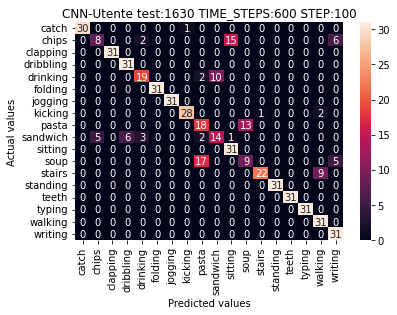

Utente test:  1631
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 40ms/step - loss: 2.0604 - accuracy: 0.2938 - f1_m: 0.1996 - val_loss: 1.8480 - val_accuracy: 0.3844 - val_f1_m: 0.2917
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3220 - accuracy: 0.5322 - f1_m: 0.4739 - val_loss: 1.5131 - val_accuracy: 0.5097 - val_f1_m: 0.4371
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0317 - accuracy: 0.6354 - f1_m: 0.6166 - val_loss: 1.2577 - val_accuracy: 0.5765 - val_f1_m: 0.5666
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 0.8528 - accuracy: 0.6973 - f1_m: 0.6915 - val_loss: 1.0396 - val_accuracy: 0.6362 - val_f1_m: 0.6283
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.7407 - accuracy: 0.7342 - f1_m: 0.7308 - val_loss: 0.9718 - val_accuracy: 0.658

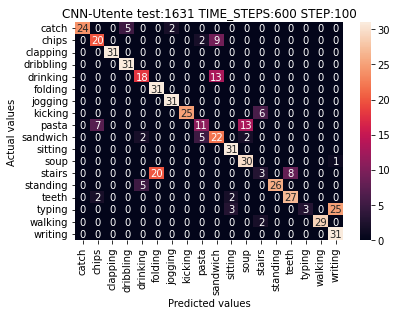

Utente test:  1632
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 40ms/step - loss: 2.0201 - accuracy: 0.3144 - f1_m: 0.2125 - val_loss: 1.5640 - val_accuracy: 0.4568 - val_f1_m: 0.3222
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2989 - accuracy: 0.5402 - f1_m: 0.4908 - val_loss: 1.2922 - val_accuracy: 0.5397 - val_f1_m: 0.5016
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0421 - accuracy: 0.6234 - f1_m: 0.5963 - val_loss: 1.0399 - val_accuracy: 0.6169 - val_f1_m: 0.5964
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 0.8837 - accuracy: 0.6745 - f1_m: 0.6582 - val_loss: 0.9948 - val_accuracy: 0.6464 - val_f1_m: 0.6405
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.7713 - accuracy: 0.7145 - f1_m: 0.7044 - val_loss: 0.8388 - val_accuracy: 0.694

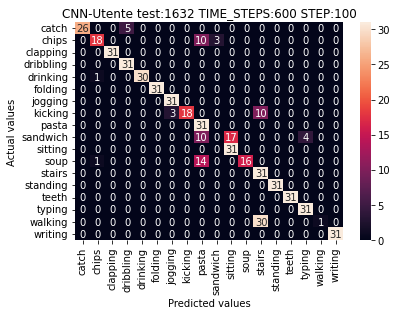

Utente test:  1634
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.0383 - accuracy: 0.2943 - f1_m: 0.2013 - val_loss: 1.6696 - val_accuracy: 0.4282 - val_f1_m: 0.3467
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3182 - accuracy: 0.5419 - f1_m: 0.4899 - val_loss: 1.1824 - val_accuracy: 0.5831 - val_f1_m: 0.5591
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0148 - accuracy: 0.6410 - f1_m: 0.6250 - val_loss: 1.0656 - val_accuracy: 0.6172 - val_f1_m: 0.6030
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 0.8356 - accuracy: 0.7043 - f1_m: 0.6969 - val_loss: 0.8866 - val_accuracy: 0.7029 - val_f1_m: 0.7034
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.7323 - accuracy: 0.7396 - f1_m: 0.7380 - val_loss: 0.8709 - val_accuracy: 0.697

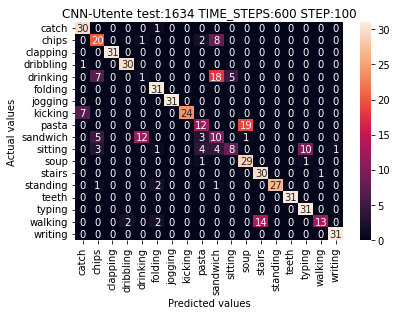

Utente test:  1635
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 39ms/step - loss: 2.0363 - accuracy: 0.3053 - f1_m: 0.2209 - val_loss: 1.7912 - val_accuracy: 0.3957 - val_f1_m: 0.3112
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.3541 - accuracy: 0.5217 - f1_m: 0.4769 - val_loss: 1.5058 - val_accuracy: 0.4993 - val_f1_m: 0.4323
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0906 - accuracy: 0.6038 - f1_m: 0.5837 - val_loss: 1.1559 - val_accuracy: 0.5906 - val_f1_m: 0.5831
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 0.9109 - accuracy: 0.6722 - f1_m: 0.6640 - val_loss: 1.1589 - val_accuracy: 0.5968 - val_f1_m: 0.5909
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.7842 - accuracy: 0.7161 - f1_m: 0.7156 - val_loss: 0.8180 - val_accuracy: 0.718

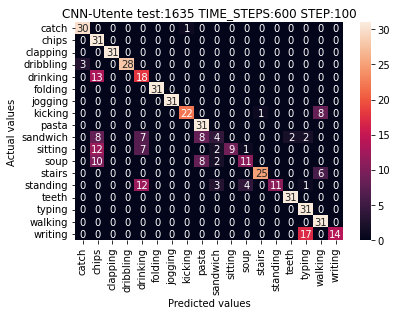

Utente test:  1641
Training: x-> 25455 y-> 25455
Validation: x-> 6364 y-> 6364
Testing: x-> 541 y-> 541
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 42ms/step - loss: 1.9982 - accuracy: 0.3091 - f1_m: 0.2056 - val_loss: 1.9255 - val_accuracy: 0.3721 - val_f1_m: 0.3436
Epoch 2/100
199/199 [==============================] - 7s 38ms/step - loss: 1.2726 - accuracy: 0.5535 - f1_m: 0.5020 - val_loss: 1.1624 - val_accuracy: 0.5838 - val_f1_m: 0.5424
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0054 - accuracy: 0.6371 - f1_m: 0.6136 - val_loss: 1.0107 - val_accuracy: 0.6452 - val_f1_m: 0.6309
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 0.8440 - accuracy: 0.6961 - f1_m: 0.6868 - val_loss: 0.9207 - val_accuracy: 0.6669 - val_f1_m: 0.6738
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.7414 - accuracy: 0.7360 - f1_m: 0.7307 - val_loss: 0.7810 - val_accuracy: 0.719

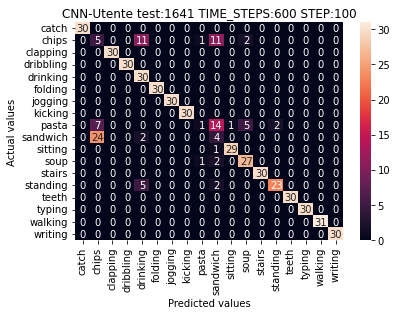

Utente test:  1643
Training: x-> 25454 y-> 25454
Validation: x-> 6364 y-> 6364
Testing: x-> 542 y-> 542
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 42ms/step - loss: 1.9683 - accuracy: 0.3319 - f1_m: 0.2484 - val_loss: 1.5593 - val_accuracy: 0.4623 - val_f1_m: 0.3769
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2740 - accuracy: 0.5478 - f1_m: 0.4963 - val_loss: 1.1808 - val_accuracy: 0.5764 - val_f1_m: 0.5120
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 0.9914 - accuracy: 0.6369 - f1_m: 0.6119 - val_loss: 0.9254 - val_accuracy: 0.6684 - val_f1_m: 0.6531
Epoch 4/100
199/199 [==============================] - 8s 38ms/step - loss: 0.8388 - accuracy: 0.6972 - f1_m: 0.6831 - val_loss: 0.9722 - val_accuracy: 0.6472 - val_f1_m: 0.6370
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.7432 - accuracy: 0.7324 - f1_m: 0.7268 - val_loss: 0.7644 - val_accuracy: 0.726

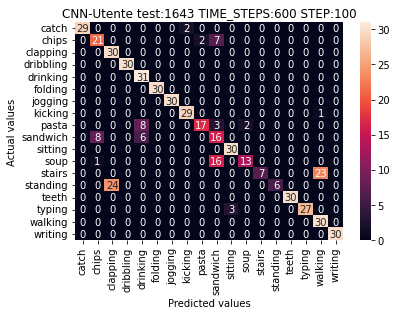

Utente test:  1645
Training: x-> 25430 y-> 25430
Validation: x-> 6358 y-> 6358
Testing: x-> 572 y-> 572
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 40ms/step - loss: 2.0213 - accuracy: 0.3115 - f1_m: 0.2246 - val_loss: 1.7260 - val_accuracy: 0.4206 - val_f1_m: 0.3534
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2915 - accuracy: 0.5427 - f1_m: 0.4957 - val_loss: 1.4157 - val_accuracy: 0.5197 - val_f1_m: 0.4953
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0124 - accuracy: 0.6401 - f1_m: 0.6123 - val_loss: 1.0033 - val_accuracy: 0.6291 - val_f1_m: 0.6017
Epoch 4/100
199/199 [==============================] - 7s 38ms/step - loss: 0.8394 - accuracy: 0.7013 - f1_m: 0.6925 - val_loss: 0.9000 - val_accuracy: 0.6809 - val_f1_m: 0.6689
Epoch 5/100
199/199 [==============================] - 8s 38ms/step - loss: 0.7361 - accuracy: 0.7391 - f1_m: 0.7337 - val_loss: 0.7339 - val_accuracy: 0.736

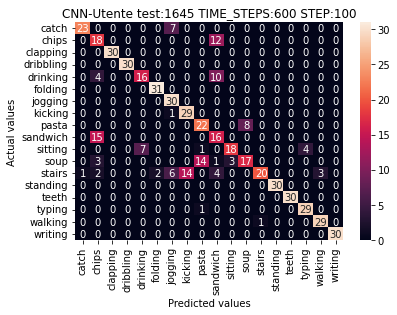

Utente test:  1646
Training: x-> 25455 y-> 25455
Validation: x-> 6364 y-> 6364
Testing: x-> 541 y-> 541
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 9s 40ms/step - loss: 2.0516 - accuracy: 0.2928 - f1_m: 0.1858 - val_loss: 1.9837 - val_accuracy: 0.3743 - val_f1_m: 0.3002
Epoch 2/100
199/199 [==============================] - 8s 38ms/step - loss: 1.2980 - accuracy: 0.5442 - f1_m: 0.4957 - val_loss: 1.4382 - val_accuracy: 0.5121 - val_f1_m: 0.4944
Epoch 3/100
199/199 [==============================] - 8s 38ms/step - loss: 1.0195 - accuracy: 0.6306 - f1_m: 0.6100 - val_loss: 1.1399 - val_accuracy: 0.6072 - val_f1_m: 0.5905
Epoch 4/100
 61/199 [========>.....................] - ETA: 4s - loss: 0.9248 - accuracy: 0.6620 - f1_m: 0.6446

In [ ]:
import itertools
import gc
from tabnanny import verbose
from tkinter import Y
batchsize=128

if leave_one_subject_out:
    cnn_results_dict = []
    cnn_results = pd.DataFrame()
    try:
        mkdir(cnn_dir + leave_one_subject_out_dir)
        mkdir(cnn_dir + leave_one_subject_out_dir + plot_dir)
    except OSError as error:
        print(error)

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        cnn_f1_macro = []
        cnn_f1_weighted = []
        cnn_acc = []
        cnn_class_reports = []
        cnn_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:
            if user_id not in notConsider:

              print("Utente test: ", user_id)

              X_test = np.array(data_cnn[time_step][step][user_id][0])
              y_test = np.array(data_cnn[time_step][step][user_id][1])

              X_train = []
              y_train = []

              for id in users_ids:
                  if not id == user_id:
                      X_train += data_cnn[time_step][step][id][0]
                      y_train += data_cnn[time_step][step][id][1]
            
              X_train = np.array(X_train)
              y_train = np.array(y_train)

              scaler = RobustScaler()
              X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
              X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

              y_train = enc.transform(y_train)
              y_test = enc.transform(y_test)

              X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
              X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

      #      print(X_train)
       #     print(y_train)
        #    print(X_test)

         #   print(y_test)

              model = createCNN(X_train[0].shape, y_train[0].shape[0])

              callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

              XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

              print("Training: x->",len(XTraining),"y->",len(YTraining))
              print("Validation: x->",len(XValidation),"y->",len(YValidation))
              print("Testing: x->",len(X_test),"y->",len(y_test))
              print("Total: x->",len(XTraining)+len(XValidation)+len(X_test),"y->",len(YTraining)+len(YValidation)+len(y_test))

              model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True, workers=10, use_multiprocessing=True )

              rounded_labels=np.argmax(y_test, axis=1)
              y_pred = np.argmax(model.predict(X_test), axis=-1)

              cnn_acc.append(accuracy_score(rounded_labels, y_pred))
              cnn_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
              cnn_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #cnn_f1.append(f1_m(rounded_labels,y_pred))

              class_report = classification_report(rounded_labels, y_pred, digits=4)
              print(class_report)
              cnn_class_reports.append(class_report)
            
              conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

              ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

              ax.set_title("CNN-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

              ax.set_xlabel('Predicted values')
              ax.set_ylabel('Actual values')

              ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
              ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

              ax.get_figure().savefig(cnn_dir + leave_one_subject_out_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
            #model_history_file=open(cnn_dir+'/'+ax.get_title().replace(":"," ")+".txt", "w")
            #model_history_file.write(model.history())
            #model_history_file.close()

              cnn_confusion_matrixes.append(ax)
              plt.show()

              gc.collect()            

        print("Accuracy media:",np.mean(cnn_acc))
        print("F1 weighted media:",np.mean(cnn_f1_weighted))
        print("F1 macro media:",np.mean(cnn_f1_macro))

        cnn_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(cnn_acc),
            'Average F1 Weighted': np.mean(cnn_f1_weighted),
            'Average F1 Macro': np.mean(cnn_f1_macro),
            'reports':cnn_class_reports,
            'confusion_matrix':cnn_confusion_matrixes
        })
        
        cnn_results = pd.DataFrame(cnn_results_dict)
        print(cnn_results)
        cnn_results.to_csv(cnn_dir + leave_one_subject_out_dir + result_filename)


[Errno 17] File exists: '2022-12-05T10_02_03\\cnn\\leave_one_subject_out'
600 100
Utente test:  1600
Training: x-> 25437 y-> 25437
Validation: x-> 6360 y-> 6360
Testing: x-> 563 y-> 563
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 16s 34ms/step - loss: 2.1736 - accuracy: 0.2884 - f1_m: 0.1493 - val_loss: 1.6833 - val_accuracy: 0.4500 - val_f1_m: 0.2756
Epoch 2/100
199/199 [==============================] - 6s 33ms/step - loss: 1.5559 - accuracy: 0.4720 - f1_m: 0.3723 - val_loss: 1.3349 - val_accuracy: 0.5410 - val_f1_m: 0.4569
Epoch 3/100
199/199 [==============================] - 6s 31ms/step - loss: 1.3183 - accuracy: 0.5500 - f1_m: 0.4797 - val_loss: 1.1392 - val_accuracy: 0.6097 - val_f1_m: 0.5529
Epoch 4/100
199/199 [==============================] - 6s 31ms/step - loss: 1.1843 - accuracy: 0.5911 - f1_m: 0.5421 - val_loss: 1.0629 - val_accuracy: 0.6252 - val_f1_m: 0.5861
Epoch 5/100
199/199 [==============================] - 6s 31ms/step - loss

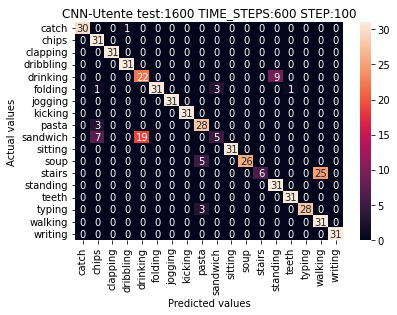

Utente test:  1601
Training: x-> 25443 y-> 25443
Validation: x-> 6361 y-> 6361
Testing: x-> 556 y-> 556
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1511 - accuracy: 0.2899 - f1_m: 0.1615 - val_loss: 1.5929 - val_accuracy: 0.4908 - val_f1_m: 0.3505
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5055 - accuracy: 0.4937 - f1_m: 0.3974 - val_loss: 1.2551 - val_accuracy: 0.5806 - val_f1_m: 0.4794
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2632 - accuracy: 0.5665 - f1_m: 0.5011 - val_loss: 1.0515 - val_accuracy: 0.6299 - val_f1_m: 0.5710
Epoch 4/100
199/199 [==============================] - 6s 32ms/step - loss: 1.1378 - accuracy: 0.6049 - f1_m: 0.5558 - val_loss: 0.9560 - val_accuracy: 0.6629 - val_f1_m: 0.6210
Epoch 5/100
199/199 [==============================] - 6s 32ms/step - loss: 1.0447 - accuracy: 0.6337 - f1_m: 0.5964 - val_loss: 0.8628 - val_accuracy: 0.704

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


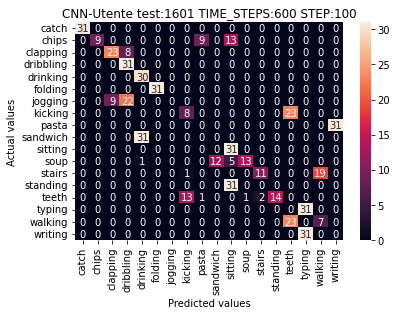

Utente test:  1602
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1016 - accuracy: 0.3118 - f1_m: 0.1807 - val_loss: 1.5913 - val_accuracy: 0.4833 - val_f1_m: 0.3386
Epoch 2/100
199/199 [==============================] - 6s 32ms/step - loss: 1.4689 - accuracy: 0.4963 - f1_m: 0.4133 - val_loss: 1.1863 - val_accuracy: 0.5986 - val_f1_m: 0.5174
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2224 - accuracy: 0.5757 - f1_m: 0.5212 - val_loss: 1.0173 - val_accuracy: 0.6406 - val_f1_m: 0.6185
Epoch 4/100
199/199 [==============================] - 6s 32ms/step - loss: 1.1120 - accuracy: 0.6119 - f1_m: 0.5709 - val_loss: 0.9250 - val_accuracy: 0.6905 - val_f1_m: 0.6623
Epoch 5/100
199/199 [==============================] - 6s 32ms/step - loss: 1.0212 - accuracy: 0.6412 - f1_m: 0.6063 - val_loss: 0.9616 - val_accuracy: 0.676

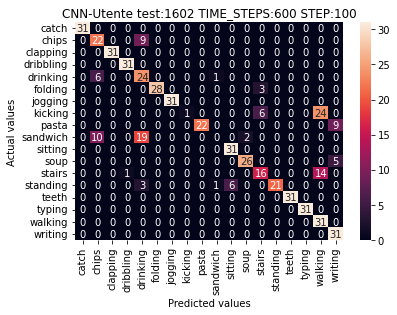

Utente test:  1603
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 7s 35ms/step - loss: 2.1118 - accuracy: 0.3102 - f1_m: 0.1705 - val_loss: 1.5978 - val_accuracy: 0.4543 - val_f1_m: 0.3328
Epoch 2/100
199/199 [==============================] - 6s 32ms/step - loss: 1.4778 - accuracy: 0.4983 - f1_m: 0.4156 - val_loss: 1.2876 - val_accuracy: 0.5314 - val_f1_m: 0.4979
Epoch 3/100
199/199 [==============================] - 6s 32ms/step - loss: 1.2628 - accuracy: 0.5677 - f1_m: 0.5091 - val_loss: 1.2066 - val_accuracy: 0.5818 - val_f1_m: 0.5156
Epoch 4/100
199/199 [==============================] - 6s 32ms/step - loss: 1.1517 - accuracy: 0.6017 - f1_m: 0.5550 - val_loss: 1.0465 - val_accuracy: 0.6258 - val_f1_m: 0.5966
Epoch 5/100
199/199 [==============================] - 6s 32ms/step - loss: 1.0707 - accuracy: 0.6269 - f1_m: 0.5931 - val_loss: 0.9971 - val_accuracy: 0.646

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


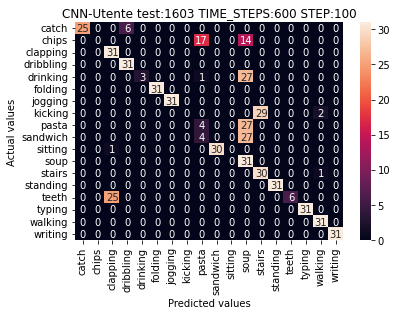

Utente test:  1604
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1079 - accuracy: 0.3027 - f1_m: 0.1765 - val_loss: 1.4931 - val_accuracy: 0.5186 - val_f1_m: 0.3853
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.4591 - accuracy: 0.5054 - f1_m: 0.4223 - val_loss: 1.2226 - val_accuracy: 0.5744 - val_f1_m: 0.5358
Epoch 3/100
199/199 [==============================] - 6s 33ms/step - loss: 1.2342 - accuracy: 0.5755 - f1_m: 0.5127 - val_loss: 1.0683 - val_accuracy: 0.6246 - val_f1_m: 0.5956
Epoch 4/100
199/199 [==============================] - 6s 33ms/step - loss: 1.0911 - accuracy: 0.6193 - f1_m: 0.5751 - val_loss: 0.9766 - val_accuracy: 0.6546 - val_f1_m: 0.6186
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.0178 - accuracy: 0.6442 - f1_m: 0.6068 - val_loss: 0.8571 - val_accuracy: 0.699

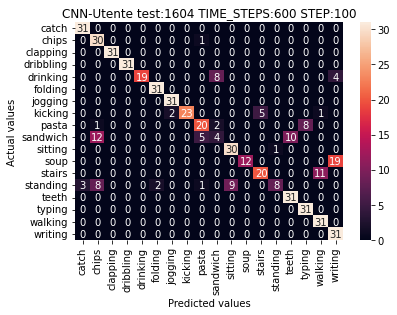

Utente test:  1605
Training: x-> 25431 y-> 25431
Validation: x-> 6358 y-> 6358
Testing: x-> 571 y-> 571
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1755 - accuracy: 0.2851 - f1_m: 0.1467 - val_loss: 1.6638 - val_accuracy: 0.4574 - val_f1_m: 0.3289
Epoch 2/100
199/199 [==============================] - 6s 33ms/step - loss: 1.5419 - accuracy: 0.4756 - f1_m: 0.3728 - val_loss: 1.2865 - val_accuracy: 0.5854 - val_f1_m: 0.4847
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.3071 - accuracy: 0.5527 - f1_m: 0.4835 - val_loss: 1.1392 - val_accuracy: 0.6147 - val_f1_m: 0.5528
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1699 - accuracy: 0.5929 - f1_m: 0.5441 - val_loss: 1.0244 - val_accuracy: 0.6450 - val_f1_m: 0.6055
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0765 - accuracy: 0.6189 - f1_m: 0.5876 - val_loss: 0.9544 - val_accuracy: 0.649

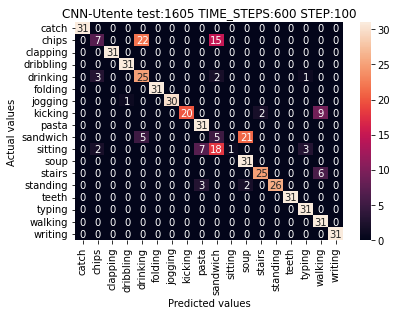

Utente test:  1606
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 7s 34ms/step - loss: 2.0998 - accuracy: 0.3040 - f1_m: 0.1739 - val_loss: 1.5881 - val_accuracy: 0.4801 - val_f1_m: 0.3223
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.5014 - accuracy: 0.4894 - f1_m: 0.4012 - val_loss: 1.2125 - val_accuracy: 0.5836 - val_f1_m: 0.5076
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2665 - accuracy: 0.5656 - f1_m: 0.5056 - val_loss: 1.0494 - val_accuracy: 0.6241 - val_f1_m: 0.5807
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1332 - accuracy: 0.6034 - f1_m: 0.5636 - val_loss: 0.9465 - val_accuracy: 0.6650 - val_f1_m: 0.6394
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.0487 - accuracy: 0.6288 - f1_m: 0.5948 - val_loss: 0.9226 - val_accuracy: 0.675

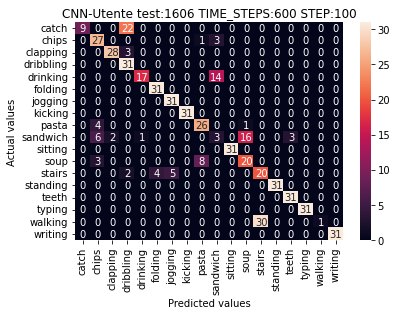

Utente test:  1607
Training: x-> 25434 y-> 25434
Validation: x-> 6359 y-> 6359
Testing: x-> 567 y-> 567
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1147 - accuracy: 0.3046 - f1_m: 0.1624 - val_loss: 1.6219 - val_accuracy: 0.4556 - val_f1_m: 0.3369
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.5118 - accuracy: 0.4897 - f1_m: 0.3995 - val_loss: 1.2626 - val_accuracy: 0.5724 - val_f1_m: 0.5033
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2982 - accuracy: 0.5572 - f1_m: 0.4897 - val_loss: 1.1343 - val_accuracy: 0.6146 - val_f1_m: 0.5476
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1766 - accuracy: 0.5907 - f1_m: 0.5366 - val_loss: 1.0192 - val_accuracy: 0.6443 - val_f1_m: 0.6032
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1012 - accuracy: 0.6133 - f1_m: 0.5690 - val_loss: 0.9724 - val_accuracy: 0.650

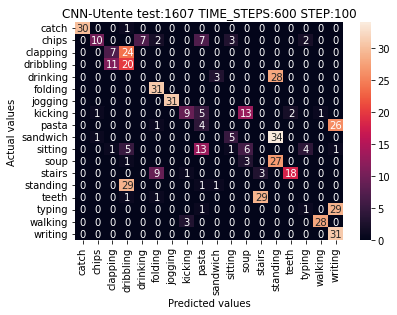

Utente test:  1608
Training: x-> 25415 y-> 25415
Validation: x-> 6354 y-> 6354
Testing: x-> 591 y-> 591
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.0765 - accuracy: 0.3114 - f1_m: 0.1803 - val_loss: 1.5951 - val_accuracy: 0.4865 - val_f1_m: 0.2943
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.4852 - accuracy: 0.5034 - f1_m: 0.4135 - val_loss: 1.2441 - val_accuracy: 0.5792 - val_f1_m: 0.5040
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2652 - accuracy: 0.5657 - f1_m: 0.5066 - val_loss: 1.1083 - val_accuracy: 0.6182 - val_f1_m: 0.5644
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1184 - accuracy: 0.6100 - f1_m: 0.5722 - val_loss: 0.9841 - val_accuracy: 0.6476 - val_f1_m: 0.6242
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.0163 - accuracy: 0.6453 - f1_m: 0.6165 - val_loss: 0.9170 - val_accuracy: 0.671

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


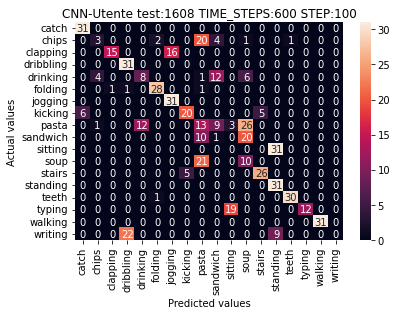

Utente test:  1609
Training: x-> 25405 y-> 25405
Validation: x-> 6352 y-> 6352
Testing: x-> 603 y-> 603
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1270 - accuracy: 0.2976 - f1_m: 0.1664 - val_loss: 1.6086 - val_accuracy: 0.4501 - val_f1_m: 0.2992
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5263 - accuracy: 0.4797 - f1_m: 0.3936 - val_loss: 1.2264 - val_accuracy: 0.5723 - val_f1_m: 0.4992
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2952 - accuracy: 0.5553 - f1_m: 0.4929 - val_loss: 1.0868 - val_accuracy: 0.6281 - val_f1_m: 0.5755
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1508 - accuracy: 0.6006 - f1_m: 0.5558 - val_loss: 0.9769 - val_accuracy: 0.6540 - val_f1_m: 0.6329
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.0619 - accuracy: 0.6260 - f1_m: 0.5912 - val_loss: 0.9086 - val_accuracy: 0.678

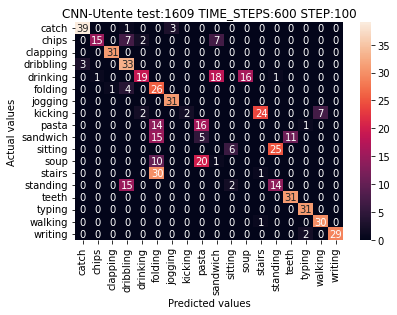

Utente test:  1610
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1315 - accuracy: 0.3008 - f1_m: 0.1680 - val_loss: 1.5252 - val_accuracy: 0.4944 - val_f1_m: 0.3480
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5260 - accuracy: 0.4828 - f1_m: 0.3934 - val_loss: 1.2760 - val_accuracy: 0.5590 - val_f1_m: 0.4526
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.3030 - accuracy: 0.5510 - f1_m: 0.4849 - val_loss: 1.0611 - val_accuracy: 0.6288 - val_f1_m: 0.5905
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1741 - accuracy: 0.5893 - f1_m: 0.5397 - val_loss: 0.9773 - val_accuracy: 0.6623 - val_f1_m: 0.6059
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0832 - accuracy: 0.6206 - f1_m: 0.5775 - val_loss: 0.9104 - val_accuracy: 0.687

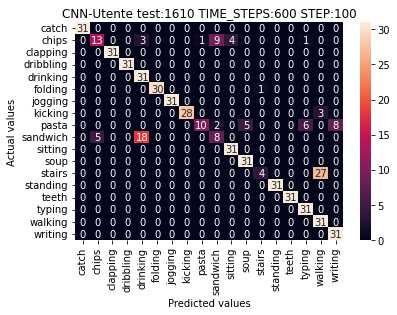

Utente test:  1611
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1472 - accuracy: 0.2925 - f1_m: 0.1596 - val_loss: 1.6502 - val_accuracy: 0.4658 - val_f1_m: 0.2963
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5123 - accuracy: 0.4850 - f1_m: 0.3954 - val_loss: 1.3921 - val_accuracy: 0.5362 - val_f1_m: 0.4609
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2726 - accuracy: 0.5606 - f1_m: 0.5025 - val_loss: 1.1634 - val_accuracy: 0.5870 - val_f1_m: 0.5506
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1252 - accuracy: 0.6141 - f1_m: 0.5696 - val_loss: 0.9610 - val_accuracy: 0.6633 - val_f1_m: 0.6268
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0355 - accuracy: 0.6375 - f1_m: 0.6046 - val_loss: 0.9312 - val_accuracy: 0.688

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


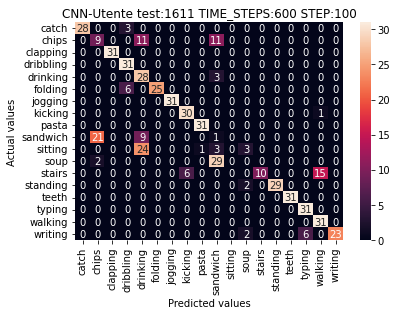

Utente test:  1612
Training: x-> 25439 y-> 25439
Validation: x-> 6360 y-> 6360
Testing: x-> 561 y-> 561
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1146 - accuracy: 0.3007 - f1_m: 0.1685 - val_loss: 1.6105 - val_accuracy: 0.4553 - val_f1_m: 0.3269
Epoch 2/100
199/199 [==============================] - 7s 35ms/step - loss: 1.5306 - accuracy: 0.4824 - f1_m: 0.3961 - val_loss: 1.3597 - val_accuracy: 0.5406 - val_f1_m: 0.4560
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.3105 - accuracy: 0.5519 - f1_m: 0.4918 - val_loss: 1.1112 - val_accuracy: 0.6082 - val_f1_m: 0.5649
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1723 - accuracy: 0.5942 - f1_m: 0.5465 - val_loss: 1.0612 - val_accuracy: 0.6283 - val_f1_m: 0.5926
Epoch 5/100
199/199 [==============================] - 7s 35ms/step - loss: 1.0802 - accuracy: 0.6235 - f1_m: 0.5828 - val_loss: 0.9882 - val_accuracy: 0.655

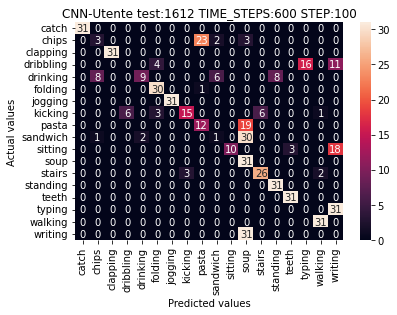

Utente test:  1613
Training: x-> 25444 y-> 25444
Validation: x-> 6361 y-> 6361
Testing: x-> 555 y-> 555
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 37ms/step - loss: 2.1866 - accuracy: 0.2789 - f1_m: 0.1469 - val_loss: 1.6747 - val_accuracy: 0.4616 - val_f1_m: 0.2769
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5658 - accuracy: 0.4677 - f1_m: 0.3747 - val_loss: 1.3029 - val_accuracy: 0.5856 - val_f1_m: 0.4629
Epoch 3/100
199/199 [==============================] - 7s 35ms/step - loss: 1.3567 - accuracy: 0.5347 - f1_m: 0.4663 - val_loss: 1.1147 - val_accuracy: 0.6115 - val_f1_m: 0.5594
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.2303 - accuracy: 0.5713 - f1_m: 0.5182 - val_loss: 1.0686 - val_accuracy: 0.6148 - val_f1_m: 0.5779
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1264 - accuracy: 0.6021 - f1_m: 0.5625 - val_loss: 0.9679 - val_accuracy: 0.662

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


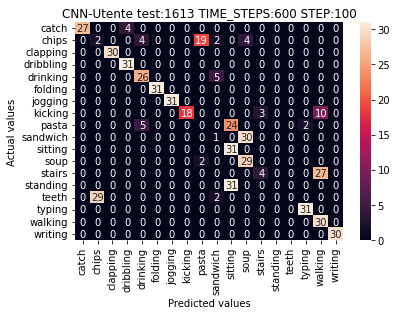

Utente test:  1614
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1764 - accuracy: 0.2857 - f1_m: 0.1504 - val_loss: 1.5819 - val_accuracy: 0.4658 - val_f1_m: 0.3339
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5163 - accuracy: 0.4870 - f1_m: 0.3976 - val_loss: 1.2226 - val_accuracy: 0.5727 - val_f1_m: 0.5184
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2869 - accuracy: 0.5564 - f1_m: 0.4902 - val_loss: 1.0872 - val_accuracy: 0.6181 - val_f1_m: 0.5784
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1676 - accuracy: 0.5982 - f1_m: 0.5476 - val_loss: 1.0518 - val_accuracy: 0.6386 - val_f1_m: 0.5964
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0642 - accuracy: 0.6299 - f1_m: 0.5904 - val_loss: 0.9853 - val_accuracy: 0.658

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


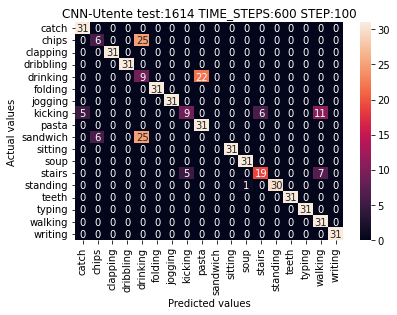

Utente test:  1615
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1137 - accuracy: 0.3113 - f1_m: 0.1825 - val_loss: 1.6747 - val_accuracy: 0.4389 - val_f1_m: 0.3241
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.5039 - accuracy: 0.4906 - f1_m: 0.3996 - val_loss: 1.2535 - val_accuracy: 0.5730 - val_f1_m: 0.4846
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2759 - accuracy: 0.5567 - f1_m: 0.4935 - val_loss: 1.1038 - val_accuracy: 0.6185 - val_f1_m: 0.5708
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1361 - accuracy: 0.6022 - f1_m: 0.5571 - val_loss: 1.0164 - val_accuracy: 0.6625 - val_f1_m: 0.5912
Epoch 5/100
199/199 [==============================] - 7s 35ms/step - loss: 1.0475 - accuracy: 0.6356 - f1_m: 0.5986 - val_loss: 0.9208 - val_accuracy: 0.690

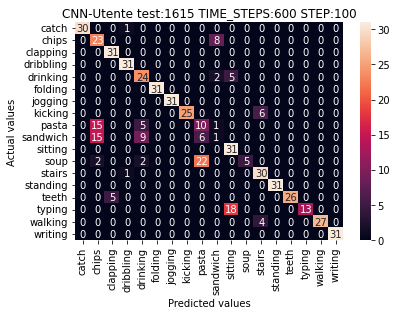

Utente test:  1616
Training: x-> 25466 y-> 25466
Validation: x-> 6367 y-> 6367
Testing: x-> 527 y-> 527
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1107 - accuracy: 0.3100 - f1_m: 0.1772 - val_loss: 1.7082 - val_accuracy: 0.4479 - val_f1_m: 0.2954
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.4992 - accuracy: 0.4953 - f1_m: 0.4042 - val_loss: 1.3172 - val_accuracy: 0.5522 - val_f1_m: 0.4862
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2806 - accuracy: 0.5615 - f1_m: 0.4977 - val_loss: 1.1622 - val_accuracy: 0.6169 - val_f1_m: 0.5567
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1371 - accuracy: 0.6080 - f1_m: 0.5635 - val_loss: 0.9873 - val_accuracy: 0.6667 - val_f1_m: 0.6340
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0417 - accuracy: 0.6412 - f1_m: 0.6039 - val_loss: 0.9600 - val_accuracy: 0.668

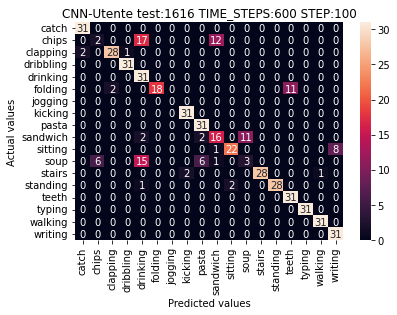

Utente test:  1617
Training: x-> 25424 y-> 25424
Validation: x-> 6357 y-> 6357
Testing: x-> 579 y-> 579
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.2820 - accuracy: 0.2490 - f1_m: 0.1139 - val_loss: 1.7861 - val_accuracy: 0.4030 - val_f1_m: 0.2486
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.6561 - accuracy: 0.4428 - f1_m: 0.3335 - val_loss: 1.4449 - val_accuracy: 0.5201 - val_f1_m: 0.3970
Epoch 3/100
199/199 [==============================] - 7s 35ms/step - loss: 1.4635 - accuracy: 0.4969 - f1_m: 0.4202 - val_loss: 1.2796 - val_accuracy: 0.5731 - val_f1_m: 0.4748
Epoch 4/100
199/199 [==============================] - 7s 33ms/step - loss: 1.3571 - accuracy: 0.5286 - f1_m: 0.4627 - val_loss: 1.1432 - val_accuracy: 0.6001 - val_f1_m: 0.5463
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2740 - accuracy: 0.5561 - f1_m: 0.5024 - val_loss: 1.0622 - val_accuracy: 0.622

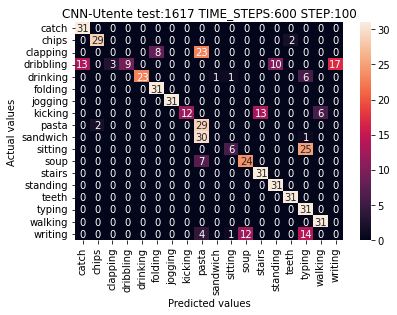

Utente test:  1618
Training: x-> 25466 y-> 25466
Validation: x-> 6367 y-> 6367
Testing: x-> 527 y-> 527
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1134 - accuracy: 0.3020 - f1_m: 0.1713 - val_loss: 1.5509 - val_accuracy: 0.4968 - val_f1_m: 0.3181
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.4797 - accuracy: 0.5018 - f1_m: 0.4094 - val_loss: 1.2112 - val_accuracy: 0.5792 - val_f1_m: 0.4979
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.2588 - accuracy: 0.5653 - f1_m: 0.5021 - val_loss: 1.0448 - val_accuracy: 0.6231 - val_f1_m: 0.5739
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1172 - accuracy: 0.6120 - f1_m: 0.5666 - val_loss: 0.9336 - val_accuracy: 0.6763 - val_f1_m: 0.6355
Epoch 5/100
199/199 [==============================] - 7s 35ms/step - loss: 1.0303 - accuracy: 0.6403 - f1_m: 0.6056 - val_loss: 0.8660 - val_accuracy: 0.694

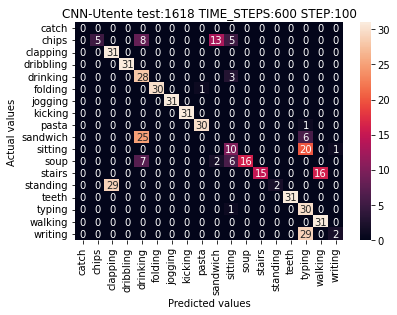

Utente test:  1619
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1354 - accuracy: 0.2962 - f1_m: 0.1718 - val_loss: 1.7036 - val_accuracy: 0.4347 - val_f1_m: 0.2996
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5226 - accuracy: 0.4851 - f1_m: 0.3939 - val_loss: 1.2812 - val_accuracy: 0.5735 - val_f1_m: 0.4777
Epoch 3/100
199/199 [==============================] - 7s 35ms/step - loss: 1.2803 - accuracy: 0.5595 - f1_m: 0.4952 - val_loss: 1.1153 - val_accuracy: 0.6159 - val_f1_m: 0.5702
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1561 - accuracy: 0.5969 - f1_m: 0.5483 - val_loss: 1.1886 - val_accuracy: 0.5919 - val_f1_m: 0.5574
Epoch 5/100
199/199 [==============================] - 7s 35ms/step - loss: 1.0641 - accuracy: 0.6264 - f1_m: 0.5840 - val_loss: 1.0124 - val_accuracy: 0.654

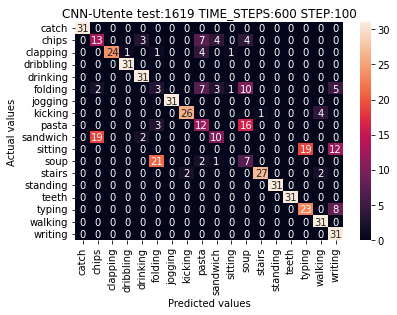

Utente test:  1620
Training: x-> 25423 y-> 25423
Validation: x-> 6356 y-> 6356
Testing: x-> 581 y-> 581
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.3061 - accuracy: 0.2458 - f1_m: 0.1163 - val_loss: 1.7707 - val_accuracy: 0.4158 - val_f1_m: 0.2439
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.6426 - accuracy: 0.4493 - f1_m: 0.3491 - val_loss: 1.3612 - val_accuracy: 0.5491 - val_f1_m: 0.4418
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.3948 - accuracy: 0.5271 - f1_m: 0.4546 - val_loss: 1.2027 - val_accuracy: 0.5883 - val_f1_m: 0.5078
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.2582 - accuracy: 0.5689 - f1_m: 0.5103 - val_loss: 1.1290 - val_accuracy: 0.5963 - val_f1_m: 0.5403
Epoch 5/100
199/199 [==============================] - 7s 33ms/step - loss: 1.1576 - accuracy: 0.5984 - f1_m: 0.5487 - val_loss: 1.0630 - val_accuracy: 0.633

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


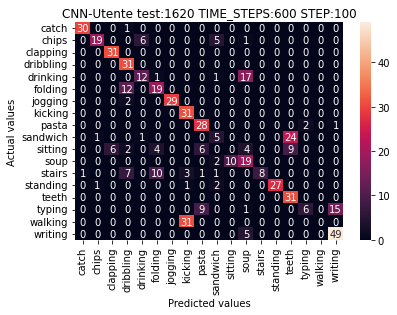

Utente test:  1621
Training: x-> 25389 y-> 25389
Validation: x-> 6348 y-> 6348
Testing: x-> 623 y-> 623
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1828 - accuracy: 0.2809 - f1_m: 0.1494 - val_loss: 1.7734 - val_accuracy: 0.4217 - val_f1_m: 0.2613
Epoch 2/100
199/199 [==============================] - 7s 35ms/step - loss: 1.5577 - accuracy: 0.4732 - f1_m: 0.3727 - val_loss: 1.3211 - val_accuracy: 0.5595 - val_f1_m: 0.4366
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.3371 - accuracy: 0.5461 - f1_m: 0.4709 - val_loss: 1.2295 - val_accuracy: 0.5761 - val_f1_m: 0.5011
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1938 - accuracy: 0.5875 - f1_m: 0.5353 - val_loss: 1.0620 - val_accuracy: 0.6498 - val_f1_m: 0.5759
Epoch 5/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1068 - accuracy: 0.6127 - f1_m: 0.5738 - val_loss: 0.9515 - val_accuracy: 0.674

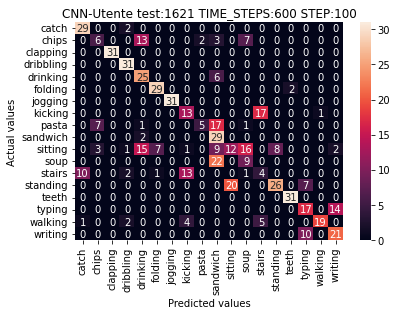

Utente test:  1622
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 35ms/step - loss: 2.1607 - accuracy: 0.2931 - f1_m: 0.1689 - val_loss: 1.5955 - val_accuracy: 0.4844 - val_f1_m: 0.2989
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.4990 - accuracy: 0.4950 - f1_m: 0.4025 - val_loss: 1.3020 - val_accuracy: 0.5612 - val_f1_m: 0.4500
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2892 - accuracy: 0.5590 - f1_m: 0.4970 - val_loss: 1.0732 - val_accuracy: 0.6238 - val_f1_m: 0.5733
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1692 - accuracy: 0.5950 - f1_m: 0.5475 - val_loss: 1.0200 - val_accuracy: 0.6425 - val_f1_m: 0.6138
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.0738 - accuracy: 0.6249 - f1_m: 0.5908 - val_loss: 0.9120 - val_accuracy: 0.680

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


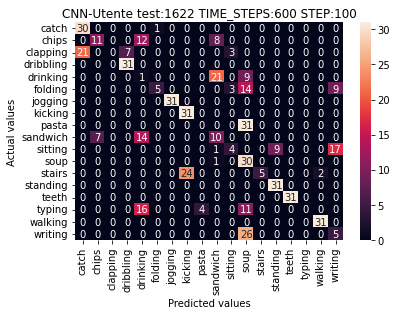

Utente test:  1623
Training: x-> 25442 y-> 25442
Validation: x-> 6361 y-> 6361
Testing: x-> 557 y-> 557
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1444 - accuracy: 0.2940 - f1_m: 0.1614 - val_loss: 1.7202 - val_accuracy: 0.4397 - val_f1_m: 0.2845
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.5348 - accuracy: 0.4786 - f1_m: 0.3895 - val_loss: 1.3192 - val_accuracy: 0.5543 - val_f1_m: 0.4687
Epoch 3/100
199/199 [==============================] - 7s 33ms/step - loss: 1.3327 - accuracy: 0.5449 - f1_m: 0.4718 - val_loss: 1.1572 - val_accuracy: 0.5991 - val_f1_m: 0.5367
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1932 - accuracy: 0.5847 - f1_m: 0.5304 - val_loss: 1.0338 - val_accuracy: 0.6499 - val_f1_m: 0.6105
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1046 - accuracy: 0.6121 - f1_m: 0.5675 - val_loss: 0.9935 - val_accuracy: 0.656

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


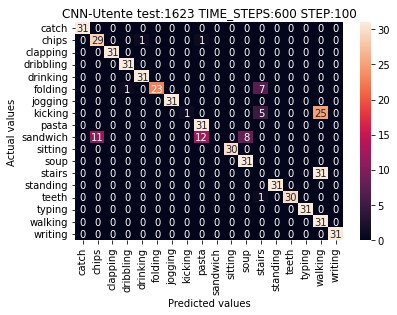

Utente test:  1624
Training: x-> 25391 y-> 25391
Validation: x-> 6348 y-> 6348
Testing: x-> 621 y-> 621
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1076 - accuracy: 0.3105 - f1_m: 0.1848 - val_loss: 1.5772 - val_accuracy: 0.4787 - val_f1_m: 0.3183
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.4790 - accuracy: 0.5051 - f1_m: 0.4240 - val_loss: 1.2802 - val_accuracy: 0.5770 - val_f1_m: 0.4647
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2549 - accuracy: 0.5708 - f1_m: 0.5152 - val_loss: 1.0388 - val_accuracy: 0.6385 - val_f1_m: 0.5884
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1244 - accuracy: 0.6115 - f1_m: 0.5662 - val_loss: 0.9800 - val_accuracy: 0.6654 - val_f1_m: 0.6193
Epoch 5/100
199/199 [==============================] - 7s 35ms/step - loss: 1.0280 - accuracy: 0.6400 - f1_m: 0.6083 - val_loss: 0.8666 - val_accuracy: 0.697

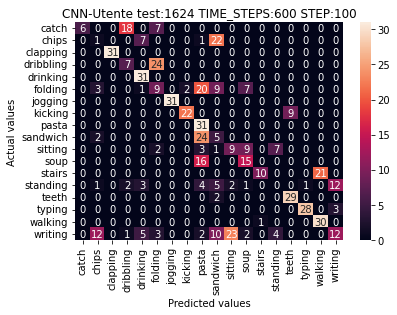

Utente test:  1625
Training: x-> 25427 y-> 25427
Validation: x-> 6357 y-> 6357
Testing: x-> 576 y-> 576
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.3060 - accuracy: 0.2400 - f1_m: 0.1161 - val_loss: 1.7153 - val_accuracy: 0.4565 - val_f1_m: 0.2456
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.6753 - accuracy: 0.4445 - f1_m: 0.3336 - val_loss: 1.3641 - val_accuracy: 0.5482 - val_f1_m: 0.4480
Epoch 3/100
199/199 [==============================] - 7s 35ms/step - loss: 1.4146 - accuracy: 0.5185 - f1_m: 0.4388 - val_loss: 1.2422 - val_accuracy: 0.5830 - val_f1_m: 0.5039
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2759 - accuracy: 0.5584 - f1_m: 0.4949 - val_loss: 1.0907 - val_accuracy: 0.6160 - val_f1_m: 0.5632
Epoch 5/100
199/199 [==============================] - 7s 34ms/step - loss: 1.1864 - accuracy: 0.5875 - f1_m: 0.5341 - val_loss: 1.0276 - val_accuracy: 0.643

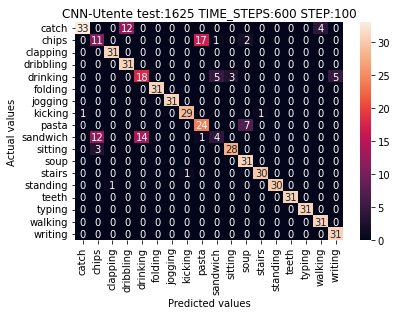

Utente test:  1626
Training: x-> 25422 y-> 25422
Validation: x-> 6356 y-> 6356
Testing: x-> 582 y-> 582
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.1721 - accuracy: 0.2858 - f1_m: 0.1562 - val_loss: 1.7531 - val_accuracy: 0.4290 - val_f1_m: 0.2858
Epoch 2/100
199/199 [==============================] - 7s 33ms/step - loss: 1.5604 - accuracy: 0.4781 - f1_m: 0.3806 - val_loss: 1.3507 - val_accuracy: 0.5472 - val_f1_m: 0.4419
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.3372 - accuracy: 0.5511 - f1_m: 0.4798 - val_loss: 1.1800 - val_accuracy: 0.6015 - val_f1_m: 0.5385
Epoch 4/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2077 - accuracy: 0.5798 - f1_m: 0.5297 - val_loss: 1.0345 - val_accuracy: 0.6503 - val_f1_m: 0.6070
Epoch 5/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1177 - accuracy: 0.6108 - f1_m: 0.5700 - val_loss: 1.0227 - val_accuracy: 0.655

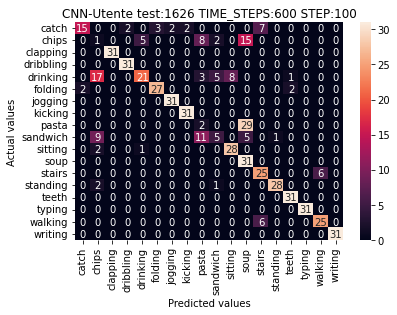

Utente test:  1627
Training: x-> 25441 y-> 25441
Validation: x-> 6361 y-> 6361
Testing: x-> 558 y-> 558
Total: x-> 32360 y-> 32360
Epoch 1/100
199/199 [==============================] - 8s 36ms/step - loss: 2.0983 - accuracy: 0.3087 - f1_m: 0.1819 - val_loss: 1.5621 - val_accuracy: 0.4729 - val_f1_m: 0.3519
Epoch 2/100
199/199 [==============================] - 7s 34ms/step - loss: 1.4898 - accuracy: 0.4997 - f1_m: 0.4148 - val_loss: 1.3552 - val_accuracy: 0.5505 - val_f1_m: 0.4602
Epoch 3/100
199/199 [==============================] - 7s 34ms/step - loss: 1.2795 - accuracy: 0.5621 - f1_m: 0.5034 - val_loss: 1.1386 - val_accuracy: 0.6131 - val_f1_m: 0.5515
Epoch 4/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1368 - accuracy: 0.6103 - f1_m: 0.5675 - val_loss: 0.9868 - val_accuracy: 0.6603 - val_f1_m: 0.6338
Epoch 5/100
199/199 [==============================] - 7s 35ms/step - loss: 1.0399 - accuracy: 0.6381 - f1_m: 0.6061 - val_loss: 0.9094 - val_accuracy: 0.687

In [ ]:
import itertools
import gc
from tabnanny import verbose
from tkinter import Y
batchsize=128

if leave_one_subject_out:
    cnn_results_dict = []
    cnn_results = pd.DataFrame()
    try:
        mkdir(cnn_dir + leave_one_subject_out_dir)
        mkdir(cnn_dir + leave_one_subject_out_dir + plot_dir)
    except OSError as error:
        print(error)

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        cnn_f1_macro = []
        cnn_f1_weighted = []
        cnn_acc = []
        cnn_class_reports = []
        cnn_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:
            print("Utente test: ", user_id)

            X_test = np.array(data_cnn[time_step][step][user_id][0])
            y_test = np.array(data_cnn[time_step][step][user_id][1])

            X_train = []
            y_train = []

            for id in users_ids:
                if not id == user_id:
                    X_train += data_cnn[time_step][step][id][0]
                    y_train += data_cnn[time_step][step][id][1]
            
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            scaler = RobustScaler()
            X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
            X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

            y_train = enc.transform(y_train)
            y_test = enc.transform(y_test)

            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

      #      print(X_train)
       #     print(y_train)
        #    print(X_test)

         #   print(y_test)

            model = createCNN(X_train[0].shape, y_train[0].shape[0])

            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

            XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

            print("Training: x->",len(XTraining),"y->",len(YTraining))
            print("Validation: x->",len(XValidation),"y->",len(YValidation))
            print("Testing: x->",len(X_test),"y->",len(y_test))
            print("Total: x->",len(XTraining)+len(XValidation)+len(X_test),"y->",len(YTraining)+len(YValidation)+len(y_test))

            model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True, workers=10, use_multiprocessing=True )

            rounded_labels=np.argmax(y_test, axis=1)
            y_pred = np.argmax(model.predict(X_test), axis=-1)

            cnn_acc.append(accuracy_score(rounded_labels, y_pred))
            cnn_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
            cnn_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #cnn_f1.append(f1_m(rounded_labels,y_pred))

            class_report = classification_report(rounded_labels, y_pred, digits=4)
            print(class_report)
            cnn_class_reports.append(class_report)
            
            conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

            ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

            ax.set_title("CNN-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

            ax.set_xlabel('Predicted values')
            ax.set_ylabel('Actual values')

            ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
            ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

            ax.get_figure().savefig(cnn_dir + leave_one_subject_out_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
            #model_history_file=open(cnn_dir+'/'+ax.get_title().replace(":"," ")+".txt", "w")
            #model_history_file.write(model.history())
            #model_history_file.close()

            cnn_confusion_matrixes.append(ax)
            plt.show()

            gc.collect()            

        print("Accuracy media:",np.mean(cnn_acc))
        print("F1 weighted media:",np.mean(cnn_f1_weighted))
        print("F1 macro media:",np.mean(cnn_f1_macro))

        cnn_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(cnn_acc),
            'Average F1 Weighted': np.mean(cnn_f1_weighted),
            'Average F1 Macro': np.mean(cnn_f1_macro),
            'reports':cnn_class_reports,
            'confusion_matrix':cnn_confusion_matrixes
        })
        
        cnn_results = pd.DataFrame(cnn_results_dict)
        print(cnn_results)
        cnn_results.to_csv(cnn_dir + leave_one_subject_out_dir + result_filename)


In [ ]:
print(np.unique(y_pred))
print(np.unique(y_test))

[ 0  1  3  4  5  6  7  8  9 10 11 13 16 17]
[0. 1.]


# Bi-LSTM

In [ ]:
bilstm_dir = folder_name + "\\bilstm"
bilstm_plot_dir = bilstm_dir + "\\plot"
bilstm_result_filename = bilstm_dir + "\\result.csv"
bilstm_config_filename = bilstm_dir + "\\config_bilstm.txt"

mkdir(bilstm_dir)
mkdir(bilstm_plot_dir)

In [ ]:
def createBiLSTM(input_size, output_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=64, return_sequences=True, input_shape=input_size)))
    model.add(Dropout(rate=0.2))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dropout(rate=0.2))

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(output_size, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    
    return model

In [ ]:
data_cnn = tuple_by_timestep

600 100
Utente test:  1600
Epoch 1/100
199/199 [==============================] - 36s 119ms/step - loss: 2.4722 - accuracy: 0.2037 - val_loss: 2.1124 - val_accuracy: 0.2931
Epoch 2/100
199/199 [==============================] - 22s 110ms/step - loss: 2.1864 - accuracy: 0.2872 - val_loss: 1.9817 - val_accuracy: 0.3426
Epoch 3/100
199/199 [==============================] - 22s 111ms/step - loss: 2.0453 - accuracy: 0.3177 - val_loss: 1.8321 - val_accuracy: 0.3887
Epoch 4/100
199/199 [==============================] - 22s 111ms/step - loss: 2.0440 - accuracy: 0.3249 - val_loss: 1.9224 - val_accuracy: 0.3575
Epoch 5/100
199/199 [==============================] - 23s 117ms/step - loss: 2.1791 - accuracy: 0.2877 - val_loss: 2.0914 - val_accuracy: 0.2991
Epoch 6/100
199/199 [==============================] - 22s 111ms/step - loss: 2.1187 - accuracy: 0.2976 - val_loss: 1.9334 - val_accuracy: 0.3508
Epoch 7/100
199/199 [==============================] - 22s 112ms/step - loss: 1.9829 - accuracy: 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        31
           1     0.5319    0.8065    0.6410        31
           2     0.0000    0.0000    0.0000        31
           3     0.9688    1.0000    0.9841        31
           4     0.2308    0.0968    0.1364        31
           5     0.8889    0.6667    0.7619        36
           6     1.0000    1.0000    1.0000        31
           7     0.3500    0.9032    0.5045        31
           8     0.3019    0.5161    0.3810        31
           9     0.0000    0.0000    0.0000        31
          10     1.0000    1.0000    1.0000        31
          11     0.3243    0.3871    0.3529        31
          12     0.5714    0.1290    0.2105        31
          13     0.8000    0.5161    0.6275        31
          14     0.3039    1.0000    0.4662        31
          15     0.7561    1.0000    0.8611        31
          16     0.3333    0.0323    0.0588        31
          17     0.8333    

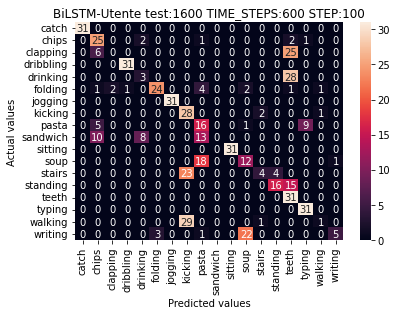

Utente test:  1602
Epoch 1/100
199/199 [==============================] - 29s 120ms/step - loss: 2.4713 - accuracy: 0.2092 - val_loss: 2.0389 - val_accuracy: 0.3309
Epoch 2/100
199/199 [==============================] - 23s 113ms/step - loss: 2.1284 - accuracy: 0.2959 - val_loss: 1.8668 - val_accuracy: 0.3677
Epoch 3/100
199/199 [==============================] - 22s 113ms/step - loss: 2.0766 - accuracy: 0.3121 - val_loss: 1.9954 - val_accuracy: 0.3193
Epoch 4/100
199/199 [==============================] - 22s 112ms/step - loss: 2.0527 - accuracy: 0.3105 - val_loss: 1.8022 - val_accuracy: 0.3767
Epoch 5/100
199/199 [==============================] - 22s 113ms/step - loss: 2.0670 - accuracy: 0.3107 - val_loss: 1.8645 - val_accuracy: 0.3603
Epoch 6/100
199/199 [==============================] - 23s 116ms/step - loss: 1.9505 - accuracy: 0.3412 - val_loss: 1.8424 - val_accuracy: 0.3638
Epoch 7/100
199/199 [==============================] - 22s 113ms/step - loss: 1.9472 - accuracy: 0.3412 -

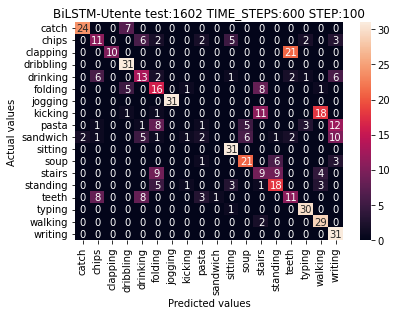

Utente test:  1604
Epoch 1/100
199/199 [==============================] - 29s 119ms/step - loss: 2.5005 - accuracy: 0.2051 - val_loss: 2.0624 - val_accuracy: 0.3166
Epoch 2/100
199/199 [==============================] - 22s 113ms/step - loss: 2.2060 - accuracy: 0.2765 - val_loss: 1.9288 - val_accuracy: 0.3691
Epoch 3/100
199/199 [==============================] - 22s 113ms/step - loss: 2.0647 - accuracy: 0.3141 - val_loss: 1.8118 - val_accuracy: 0.3921
Epoch 4/100
199/199 [==============================] - 22s 112ms/step - loss: 1.9809 - accuracy: 0.3429 - val_loss: 1.8453 - val_accuracy: 0.3841
Epoch 5/100
199/199 [==============================] - 22s 113ms/step - loss: 1.9596 - accuracy: 0.3450 - val_loss: 1.7338 - val_accuracy: 0.4080
Epoch 6/100
199/199 [==============================] - 23s 118ms/step - loss: 1.9532 - accuracy: 0.3468 - val_loss: 1.7230 - val_accuracy: 0.4243
Epoch 7/100
199/199 [==============================] - 22s 112ms/step - loss: 1.8917 - accuracy: 0.3640 -

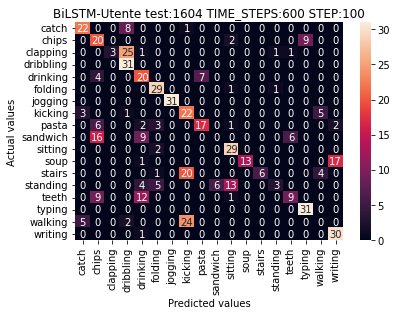

Utente test:  1605
Epoch 1/100
199/199 [==============================] - 31s 126ms/step - loss: 2.4947 - accuracy: 0.2018 - val_loss: 2.0990 - val_accuracy: 0.2891
Epoch 2/100
 31/199 [===>..........................] - ETA: 17s - loss: 2.2211 - accuracy: 0.2656

KeyboardInterrupt: ignored

In [ ]:
import itertools
import gc
bilstm_results_dict = []
bilstm_results = pd.DataFrame()

if bilstm_one_subject_out:

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        bilstm_f1_weighted = []
        bilstm_f1_macro = []
        bilstm_acc = []
        bilstm_class_reports = []
        bilstm_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:
          if user_id not in notConsider:

              print("Utente test: ", user_id)

              X_test = np.array(data_cnn[time_step][step][user_id][0])
              y_test = np.array(data_cnn[time_step][step][user_id][1])

              X_train = []
              y_train = []

              for id in users_ids:
                  if id != user_id:
                      X_train += data_cnn[time_step][step][id][0]
                      y_train += data_cnn[time_step][step][id][1]
            
              X_train = np.array(X_train)
              y_train = np.array(y_train)

              y_train = enc.transform(y_train)
              y_test = enc.transform(y_test)

              scaler = RobustScaler()
              X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
              X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
            
            #X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
            #X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

              model = createBiLSTM([X_train[0].shape[0], X_train[0].shape[1]], y_train[0].shape[0])

              callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True, restore_best_weights=True)

              XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

              model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True )
            
              rounded_labels=np.argmax(y_test, axis=1)
              y_pred = np.argmax(model.predict(X_test), axis=-1)

              bilstm_acc.append(accuracy_score(rounded_labels, y_pred))
              bilstm_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
              bilstm_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #bilstm_f1.append(f1_m(rounded_labels,y_pred))

              class_report = classification_report(rounded_labels, y_pred, digits=4)
              print(class_report)
              bilstm_class_reports.append(class_report)
            
              conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

              ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

              ax.set_title("BiLSTM-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

              ax.set_xlabel('Predicted values')
              ax.set_ylabel('Actual values')

              ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
              ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

              ax.get_figure().savefig(bilstm_plot_dir+'/'+ax.get_title().replace(":"," ")+".png", dpi=500)

              bilstm_confusion_matrixes.append(ax)
              plt.show()

              gc.collect()





            

        print("Accuracy media:",np.mean(bilstm_acc))
        print("F1 media macro:",np.mean(bilstm_f1_macro))
        print("F1 media weighted:",np.mean(bilstm_f1_macro))

        bilstm_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(bilstm_acc),
            'Average F1 weighted': np.mean(bilstm_f1_weighted),
            'Average F1 macro': np.mean(bilstm_f1_macro),
            'reports':bilstm_class_reports,
            'confusion_matrix':bilstm_confusion_matrixes
        })

    bilstm_config_file = open(bilstm_config_filename, "a")
    model.summary(print_fn=lambda x: bilstm_config_file.write(x))
    bilstm_config_file.close()

In [ ]:
bilstm_results_dataframe = pd.DataFrame(bilstm_results_dict)
bilstm_results_dataframe.to_csv(bilstm_result_filename)
bilstm_results_dataframe

# SHALLOW LEARNING

## Random Forest

In [ ]:
rf_dir = folder_name + "\\rf"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

try:
    mkdir(rf_dir )
    mkdir(rf_dir + plot_dir)
except OSError as error:
    print(error)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 26.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.5s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

              precision    recall  f1-score   support

       catch       1.00      0.77      0.87        31
       chips       0.67      1.00      0.81        31
    clapping       0.91      0.65      0.75        31
   dribbling       0.82      1.00      0.90        31
    drinking       0.57      0.77      0.66        31
     folding       1.00      0.94      0.97        36
     jogging       1.00      1.00      1.00        31
     kicking       1.00      1.00      1.00        31
       pasta       0.47      0.52      0.49        31
    sandwich       0.00      0.00      0.00        31
     sitting       1.00      1.00      1.00        31
        soup       1.00      0.84      0.91        31
      stairs       1.00      0.94      0.97        31
    standing       1.00      1.00      1.00        31
       teeth       0.63      1.00      0.78        31
      typing       1.00      1.00      1.00        31
     walking       0.94      1.00      0.97        31
     writing       1.00    

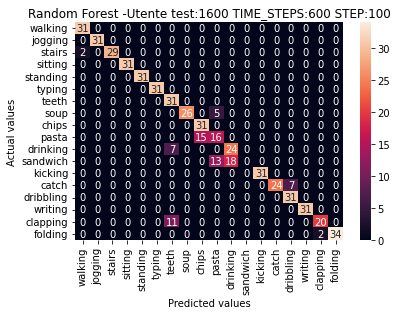

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 25.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.5s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

              precision    recall  f1-score   support

       catch       0.51      1.00      0.67        31
       chips       0.20      0.19      0.20        31
    clapping       0.00      0.00      0.00        31
   dribbling       0.00      0.00      0.00        31
    drinking       0.35      1.00      0.52        30
     folding       0.62      0.48      0.55        31
     jogging       1.00      1.00      1.00        31
     kicking       0.00      0.00      0.00        31
       pasta       0.00      0.00      0.00        31
    sandwich       0.00      0.00      0.00        31
     sitting       0.00      0.00      0.00        31
        soup       1.00      0.42      0.59        31
      stairs       0.67      0.97      0.79        31
    standing       0.00      0.00      0.00        31
       teeth       0.00      0.00      0.00        31
      typing       0.33      1.00      0.50        31
     walking       0.00      0.00      0.00        30
     writing       0.00    

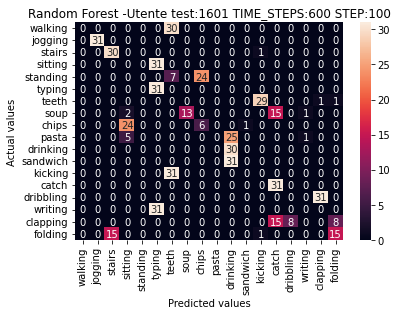

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 26.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.6s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

              precision    recall  f1-score   support

       catch       1.00      0.58      0.73        31
       chips       0.83      0.61      0.70        31
    clapping       0.86      0.97      0.91        31
   dribbling       0.61      1.00      0.76        31
    drinking       0.42      1.00      0.59        31
     folding       0.68      0.42      0.52        31
     jogging       1.00      1.00      1.00        31
     kicking       1.00      0.55      0.71        31
       pasta       0.00      0.00      0.00        31
    sandwich       0.00      0.00      0.00        31
     sitting       0.89      1.00      0.94        31
        soup       0.79      1.00      0.89        31
      stairs       0.46      0.94      0.62        31
    standing       1.00      0.68      0.81        31
       teeth       0.96      0.84      0.90        31
      typing       1.00      1.00      1.00        31
     walking       0.91      0.65      0.75        31
     writing       0.60    

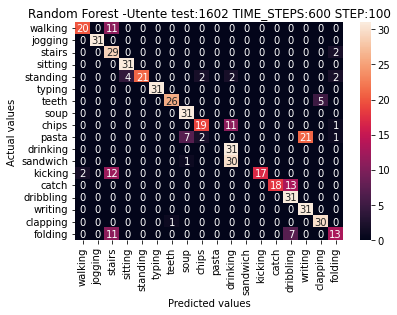

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 26.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.5s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

              precision    recall  f1-score   support

       catch       0.72      1.00      0.84        31
       chips       0.00      0.00      0.00        31
    clapping       0.61      1.00      0.76        31
   dribbling       0.00      0.00      0.00        31
    drinking       0.00      0.00      0.00        31
     folding       1.00      0.55      0.71        31
     jogging       1.00      1.00      1.00        31
     kicking       0.54      1.00      0.70        31
       pasta       0.00      0.00      0.00        31
    sandwich       0.00      0.00      0.00        31
     sitting       0.00      0.00      0.00        31
        soup       0.20      1.00      0.34        31
      stairs       0.00      0.00      0.00        31
    standing       1.00      1.00      1.00        31
       teeth       0.00      0.00      0.00        31
      typing       1.00      1.00      1.00        31
     walking       0.50      1.00      0.67        31
     writing       0.94    

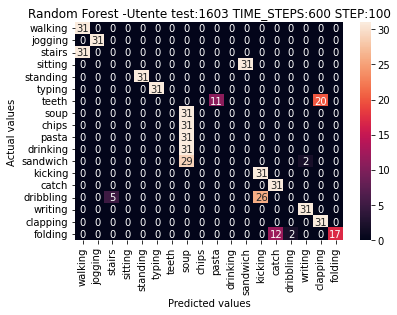

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.8min


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

rf_results = []

gc.collect()
for config in itertools.product(time_steps_list, step_list):



    time_step = config[0]
    step=config[1]

    tuple = tuple_by_timestep[time_steps][step]

    f1_list = []
    acc_list = []

    for user_id in users_ids:

        x_test = tuple[user_id][0]
        y_test = tuple[user_id][1]

        x_train = []
        y_train = []

        for id in users_ids:
            if id != user_id:
                x_train+=tuple[id][0]
                y_train+=tuple[id][1]
        
        x_train = [x_train[i].flatten() for i in range(len(x_train)) ]
        x_test = [x_test[i].flatten() for i in range(len(x_test))]

        y_train = np.array(y_train).flatten()
        y_test = np.array(y_test).flatten()

        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        model = RandomForestClassifier(n_jobs=-1,n_estimators=1000,random_state=seed, verbose=True)

        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        conf_mat = confusion_matrix(y_test, y_pred, labels=classes)

        f1 = f1_score(y_test, y_pred, average='weighted')
        acc = accuracy_score(y_test, y_pred)

        print(classification_report(y_test, y_pred))

        ax = seaborn.heatmap(conf_mat, annot=True, fmt='d')

        ax.set_title("Random Forest -Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))
        ax.get_figure().savefig(rf_dir+plot_dir+'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
        ax.set_xlabel('Predicted values')
        ax.set_ylabel('Actual values')

        ax.xaxis.set_ticklabels(classes, rotation=90)
        ax.yaxis.set_ticklabels(classes, rotation=0)


        print("f1: ", f1)
        print("acc: ", acc)

        f1_list.append(f1)
        acc_list.append(acc)


        plt.show()
    
    print("F1 total: ", np.mean(f1_list))
    print("Accuracy total: ", np.mean(acc_list))

    rf_results.append({
    'Time Steps':time_step,
    'Step':step,
    'Average accuracy':np.mean(acc_list),
    'Average F1': np.mean(f1_list),
    })

rf_results_df = pd.DataFrame(rf_results)
rf_results_df.to_csv(rf_dir + result_filename)
print(rf_results_df)


## SVM

In [ ]:
svm_dir = folder_name + "\\svm"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

try:
    mkdir(svm_dir )
    mkdir(svm_dir + plot_dir)
except OSError as error:
    print(error)

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

svm_results = []

gc.collect()
for config in itertools.product(time_steps_list, step_list):

    time_step = config[0]
    step=config[1]

    tuple = tuple_by_timestep[time_steps][step]

    f1_macro_list = []
    f1_weighted_list = []
    acc_list = []

    for user_id in users_ids:

        x_test = tuple[user_id][0]
        y_test = tuple[user_id][1]

        x_train = []
        y_train = []

        for id in users_ids:
            if id != user_id:
                x_train+=tuple[id][0]
                y_train+=tuple[id][1]
        
        x_train = [x_train[i].flatten() for i in range(len(x_train)) ]
        x_test = [x_test[i].flatten() for i in range(len(x_test))]

        y_train = np.array(y_train).flatten()
        y_test = np.array(y_test).flatten()

        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        #model = RandomForestClassifier(n_jobs=-1,n_estimators=1000,random_state=seed, verbose=True)
        model = SVC(kernel='linear',random_state=seed, verbose=1)

        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        conf_mat = confusion_matrix(y_test, y_pred, labels=classes)

        f1_w = f1_score(y_test, y_pred, average='weighted')
        f1_m = f1_score(y_test, y_pred, average='macro')
        acc = accuracy_score(y_test, y_pred)

        print(classification_report(y_test, y_pred))

        ax = seaborn.heatmap(conf_mat, annot=True, fmt='d')

        ax.set_title("SVM -Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))
        ax.get_figure().savefig(svm_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
        ax.set_xlabel('Predicted values')
        ax.set_ylabel('Actual values')

        ax.xaxis.set_ticklabels(classes, rotation=90)
        ax.yaxis.set_ticklabels(classes, rotation=0)


        print("f1 macro: ", f1_m)
        print("f1 weighted: ", f1_w)
        print("acc: ", acc)

        f1_macro_list.append(f1_m)
        f1_weighted_list.append(f1_w)
        acc_list.append(acc)


        plt.show()
    
    print("F1 weighted total: ", np.mean(f1_weighted_list))
    print("F1 macro total: ", np.mean(f1_macro_list))
    print("Accuracy total: ", np.mean(acc_list))

    svm_results.append({
    'Time Steps':time_step,
    'Step':step,
    'Average accuracy':np.mean(acc_list),
    'Average F1 macro': np.mean(f1_macro_list),
    'Average F1 weighted': np.mean(f1_weighted_list)
    })

svm_results_df = pd.DataFrame(svm_results)
svm_results_df.to_csv(svm_dir + result_filename)
print(svm_results_df)



In [ ]:
svm_results_df

In [ ]:
print("F1 weighted total: ", np.mean(f1_weighted_list))
print("F1 macro total: ", np.mean(f1_macro_list))
print("Accuracy total: ", np.mean(acc_list))